# Welcome to the HDMM-NN Tutorial!

### Some notes of caution

Please keep in mind that this tutorial provides a platform for testing the **alpha version** of this **HDDM** extension accompanying our [paper](https://www.biorxiv.org/content/10.1101/2020.11.20.392274v1) in which we develop likelihood approximation networks (LANs) for efficient inference of arbitrary simulation models.  We are working on improvements to enhance visualization and various other features. Please let us know on the HDDM forum and/or via github reports regarding bugs or other limitations and we will do our best to help as soon as we can.

Things to look out for at this point:
 
 - Networks were trained over a fairly wide range of parameters likely to capture the scope of common empirical data. The networks will not accurately report likelihoods outside that range, so we explicitly limit the range of parameters that can be sampled from. If you find that your posterior samples reach and get stuck at the allowed parameter bounds (which you will see in the posterior plots), please notify us and we can simply retrain the networks over a broader range of use cases over time.
 
 - Our companion paper describes two network architectures, an `MLP` and a `CNN`. At this point you can only use the `MLP` with HDDM, since it operates on a trial by trial basis. We are working on including the `CNN` method as soon as possible.
 
 - The `HDDMnnRegressor` class is not yet fully robust with respect to parameter bound violations introduced through the regression backend. If you run into problem, we greatly appreciate hearing about it ASAP.
 
 - **Saving** an HDDMnn model (`yourmodel.save()`) does currently not work, due to issues with pickling the neural nets. We are working to resolve this. You can however save your posterior samples separately of course (e.g. `pickle.dump(mysamples, open(fname, 'wb'))`). This refers only to sampling whole HDDM model object classes.

Lastly, you may encounter more print output than with standard HDDM. Please don't worry about this. Over time this verbosity will vanish, it helps us check if everything works as expected.

# SECTION 0.0: COLAB PREP

## Reminder
In the *upper left* menu click on **Runtime**, then **Change runtime type** and select **GPU** as **hardware accelerator**

### INSTALLATION COLAB: 1 MOUNT YOUR GOOGLE DRIVE


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

### INSTALLATION COLAB: 2 SWITCH TO TUTORIAL FOLDER

In [ ]:
%cd gdrive/'My Drive'/hddmnn_tutorial

### INSTALLATION COLAB: 3 INSTALL SUPPORT LIBRARIES

### Note 
You may get a warning about a version of `gast` package. 
Don't worry about this, it does not affect us.

In [ ]:
#!pip uninstall tensorflow  # tf 2.3.0 is loaded by default --> very slow on our networks
!pip install tensorflow-gpu==1.15 # tf 1.15 ~ 4 times faster (feel free to test this out)
!pip install pymc
!pip install kabuki

# Note you may get a warning about a version of 'gast'. 
# Don't worry about this, it does not affect us.

### INSTALLATION COLAB: 4 INSTALL HDDM

In [ ]:
!pip install -U --no-deps git+https://github.com/alexanderfengler/hddm@nn_likelihood

# SECTION 0.1: IMPORTS (ANY SETUP)

In [1]:
# MODULE IMPORTS ----

# 
import hddm

# Make simulators visible
import sys
sys.path.append('simulators')

# Data management
import pandas as pd
import numpy as np
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

# CUSTOM IMPORTS (LOCAL FILES) --------
import cddm_data_simulation as cds
import boundary_functions as bf

from helper_functions import simulator
from helper_functions import simulator_covariate
from helper_functions import simulator_stimcoding
from helper_functions import model_plot
from helper_functions import caterpillar_plot
from helper_functions import posterior_pair_plot
from helper_functions import simulator_condition_effects
from helper_functions import make_parameter_sets
from helper_functions import _make_trace_plotready_condition
from helper_functions import hddm_preprocess
from helper_functions import simulator_hierarchical
from helper_functions import posterior_predictive_plot
from helper_functions import hddm_include_config
from helper_functions import bin_simulator_output
from helper_functions import bin_simulator_output_pointwise
# --------------------------------------

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


# SECTION 1: MODEL INFO / SIMULATION / BASIC PLOTTING

The main concern of this notebook is to present the extended capabilities of the HDDM toolbox as a result of the new `HDDMnn` classes.

Primarily we are interested in the additional models we can now be fit to data. So let's take stock of the models that were added to standard **HDDM**.

### ANGLE

A model with a linearly collapsing angle. Adds a parameter $\theta$, which specifies the angle of the bound.

### WEIBULL

A model that includes a collapsing bound parameterized as the scaled *cdf* of a Weibull distribution.
This adds two parameters to the standard **DDM**, $\alpha$ and $\beta$.

### FAST FULL DDM

This is a faster version of the standard **FULL DDM**. Not a new model per se, but bypassing numerical integration for likelihood evaluations it achieves significant speed-up relatively to the basic **HDDM** version.

### LEVY

The Levy model is essentially a standard **DDM** where noise is not driven by a Gaussian distribution, but the noise process is now parameterized by the new parameter $\alpha$, which interpolates between a Gausian $\alpha = 2$ and a Cauchy (heavy tailed) $\alpha = 1$.

### ORNSTEIN

This model implements the 2-choice **LCA**, which includes a an inhibition / excitation parameter $g$. 

Find more details on these models in our companion paper. 

This section provides you *boiler-plate code* to simulate the respective models, and introduces some of the plots we provide which you may find useful. First, let's define some metadata which you can then change according to the model you want to investigate.

### Note

You can **skip** this part if you just want to see how to fit these models to data.

In [4]:
# Metadata
model = 'ddm'
n_samples = 500
includes = hddm_include_config[model]
p_outlier = [] # empty of ['p_outlier']
includes += p_outlier

Let's start by generating some parameters.

In [5]:
# LETS START WITH MAKING SOME PARAMETERS FOR OUR MODEL OF CHOICE
params = make_parameter_sets(model = model,
                                   n_parameter_sets = 5,
                                   param_dict = {'v': [i for i in np.linspace(0.5, 2.5, 5)]})

The parameter:  v , is out of the accepted bounds [ -2 , 2 ]


In [4]:
params

Now let's simulate some data from the model.

In [16]:
simulations = simulator(theta = params.values[0],
                        model = model, 
                        n_samples = n_samples,
                        max_t = 20.0,
                        bin_pointwise = False)

In [18]:
params.values[1]

array([0.89847659, 0.875     , 0.33549371, 0.82001826])

In [19]:
simulations[2]

{'v': 0.4721832275390625,
 'a': 0.5,
 'w': 0.43529170751571655,
 'ndt': 0.40116313099861145,
 's': 1.0,
 'delta_t': 0.0010000000474974513,
 'max_t': 10.0,
 'n_samples': 500,
 'simulator': 'ddm_flexbound',
 'boundary_fun_type': 'constant',
 'possible_choices': [-1, 1]}

Now that we have our simulated data, we look to visualise it.
Let's look at a couple of plots that we can use for this purpose.

The `model_plot()` is fairly flexible, and used through the tutorial. 

As a start, it allows you to plot simulations from a model, displayed as two histograms. 

- The top histogram refers to the probability of choosing option $1$ across time.
- The bottom (upside-down) histogram refers to the probability of choosing option $-1$ (may be coded as $0$ as well) across time.

The plot has many *style parameters* that you can set as well. 

(It is however still in development, so improvements are going to trickle in.)

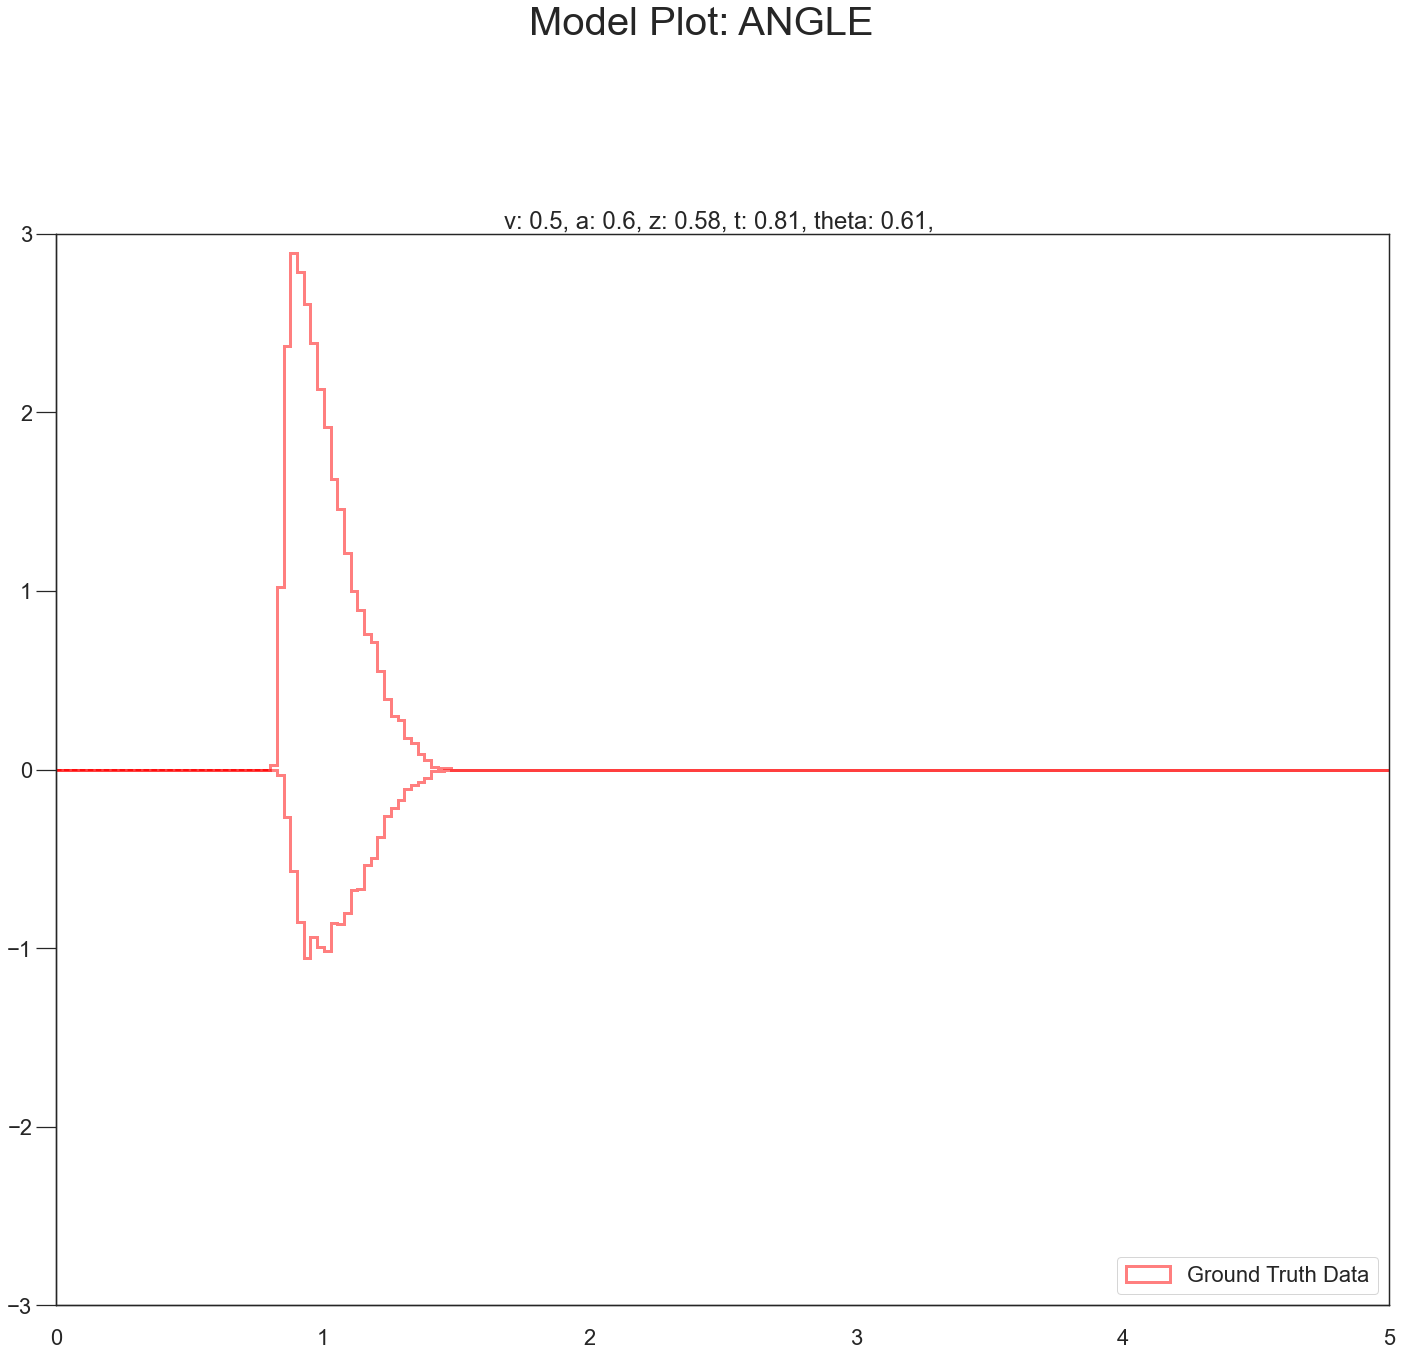

In [7]:
# Model Plots (Only data)
model_plot(ground_truths_parameters = params.values[0],
           posterior_samples = None,
           ground_truths_data = None, #np.concatenate([simulations[0], simulations[1]], axis = 1),
           cols = 1, 
           model_gt = model,
           datatype = 'single_subject',
           n_plots = 1,
           max_t = 5,
           ylimit = 3,
           posterior_linewidth = 3,
           gt_linewidth = 3,
           hist_linewidth = 3,
           bin_size = 0.025,
           show_model = False)

If we set `show_model = True`, the `model_plot()` function will add a visualization of the ground truth model on top of the histograms. 

We will see later, that we can use this functionality to also add posterior predictives, as well as model visualizations in accordance with posterior samples.

### Note

This functionality is not yet implemented for all models. 
The basic `posterior_predictive()` can on the other hand be used for all models.

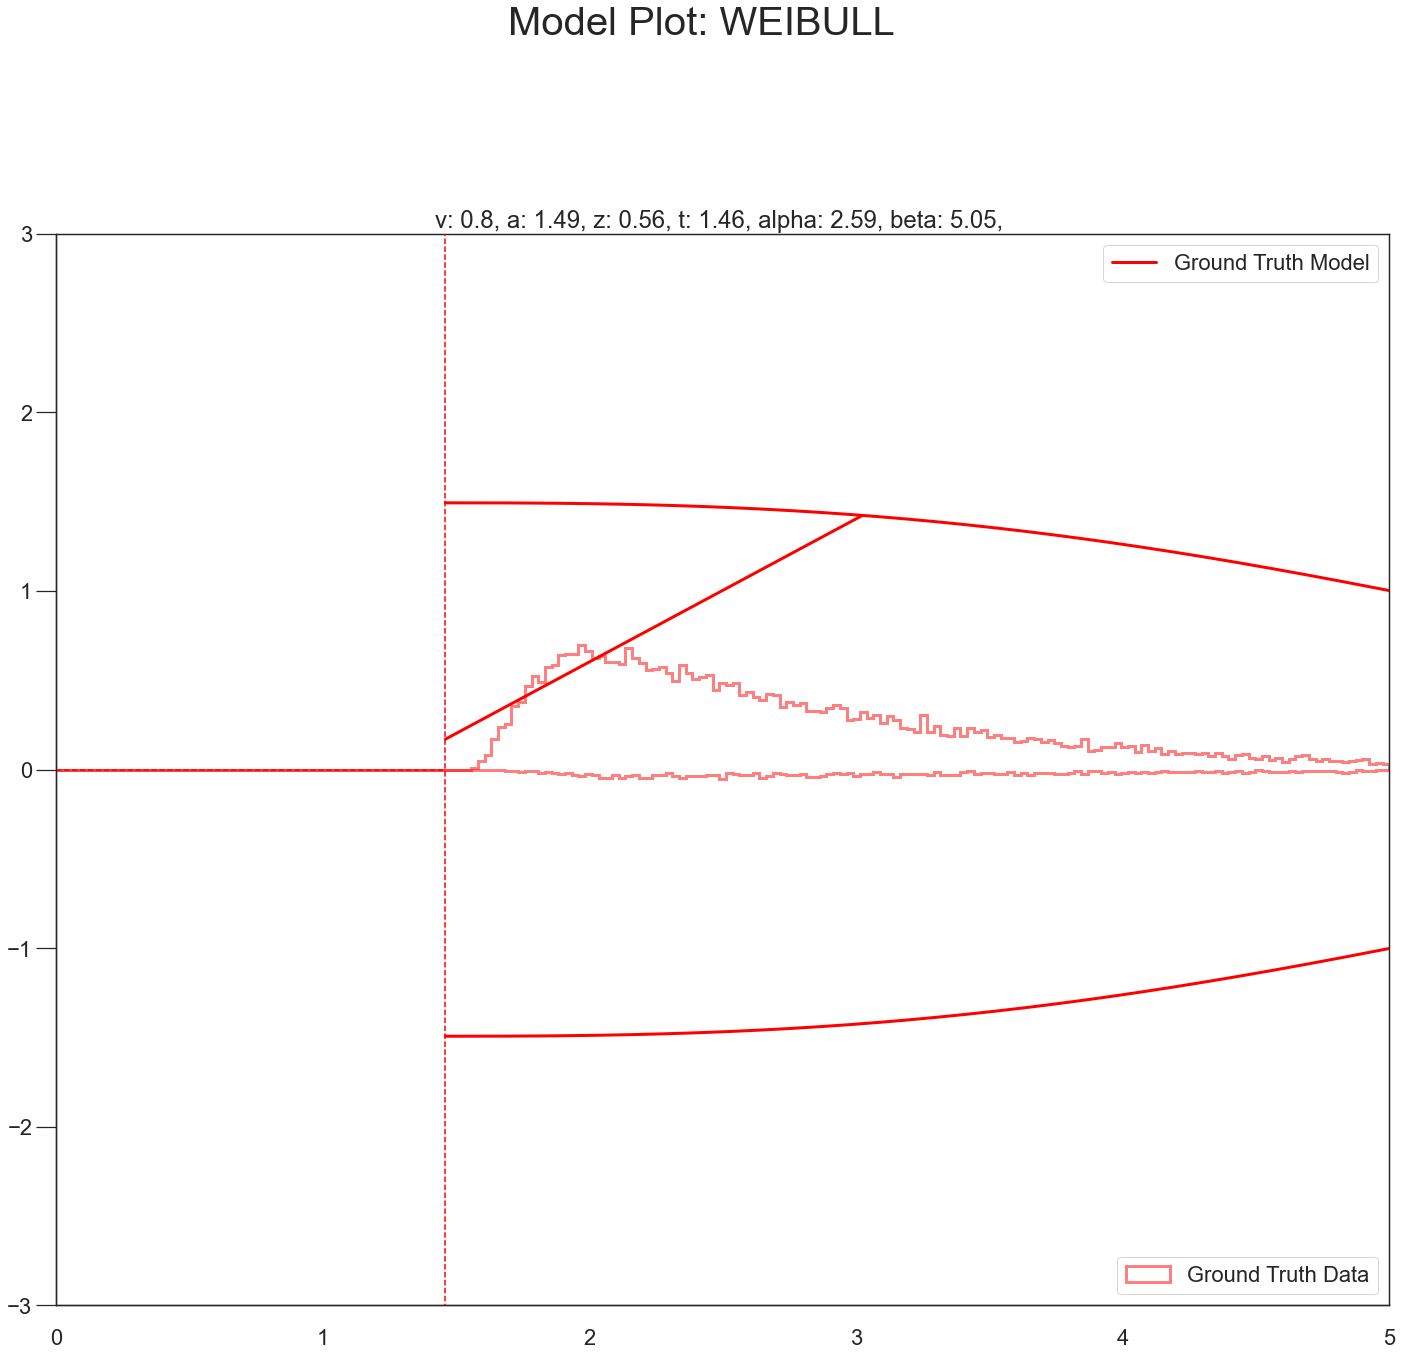

In [19]:
# Model Plots (Only data)
model_plot(ground_truths_parameters = params.values[0],
           posterior_samples = None,
           ground_truths_data = None, #np.concatenate([simulations[0], simulations[1]], axis = 1),
           cols = 1, 
           model_gt = model,
           datatype = 'single_subject',
           n_plots = 1,
           max_t = 5,
           ylimit = 3,
           posterior_linewidth = 3,
           gt_linewidth = 3,
           hist_linewidth = 3,
           bin_size = 0.025,
           show_model = True)

### Varying parameters

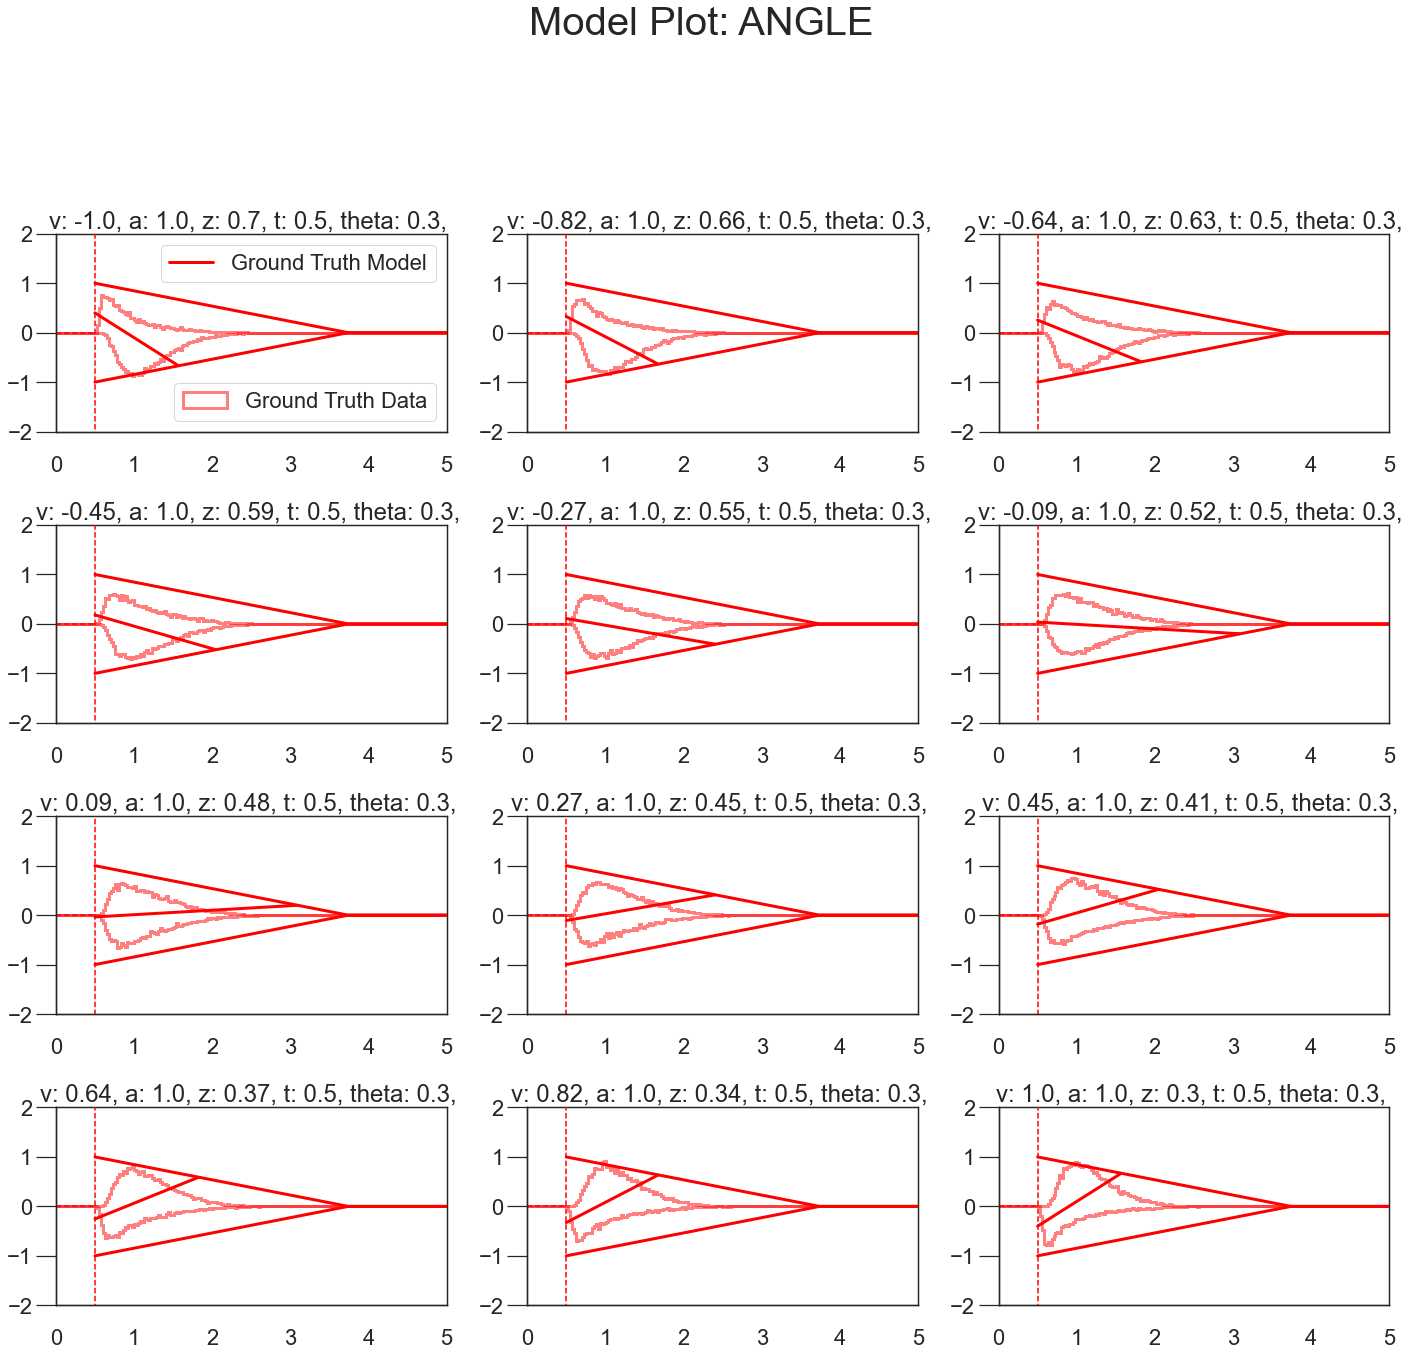

In [16]:
# Plotting the data
n_parameter_sets = 12
show_model = True
params = make_parameter_sets(model = model,
                             n_parameter_sets = n_parameter_sets,
                             param_dict = {'a': [1.],
                                           'v': [i for i in np.linspace(-1, 1, n_parameter_sets)],
                                           'z': [i for i in np.linspace(0.7, 0.3, n_parameter_sets)],
                                           'theta': [0.3], # NOTE THIS IS A MODEL SPECIFIC PARAMETER
                                           't': [0.5]})

# Model Plots (Only data)
model_plot(ground_truths_parameters = params.values,
           cols = 3, 
           model_gt = model,
           n_plots = n_parameter_sets,
           max_t = 5,
           show_model = show_model)

If you are interested, you can use this code to investigate the effects of the other parameters.

# SECTION 2: SINGLE SUBJECT (COLLAPSED) DATA


Now, we try to fit these models to data! Let's start with an simple dataset. In other words, we have one single participant who provides  $n$ datatpoints (reaction times and choices) from some *two alternative forced choice* task paradigm.


#### Note

In this demo we fit to simulated data. This serves as a template, and you can easily adapt it to your needs. 

In [2]:
# Metadata
nmcmc = 500
model = 'ddm'
n_samples = 1000
includes = hddm_include_config[model]
p_outlier = [] # empty of ['p_outlier']
includes += p_outlier

In [3]:
# MAKE DATA AND PREPARE FOR HDDM
params = make_parameter_sets(model = model,
                             n_parameter_sets = 1)

simulations = simulator(theta = params.values[0],
                        model = model,
                        n_samples = n_samples)

# Preprocess the data to be ready for HDDM
hddm_data_single_subject = hddm_preprocess(simulations)

In [4]:
# Check parameterization
params

,v,a,z,t
0,-1.778433,0.603272,0.311114,1.168686


In [5]:
# Check dataset
hddm_data_single_subject.head()

,rt,response,nn_response,subj_idx
0,1.285686,0,-1,none
1,1.750682,0,-1,none
2,1.219686,0,-1,none
3,1.706683,0,-1,none
4,1.203686,0,-1,none


In [6]:
# Define the HDDM model
hddm_model = hddm.HDDMnn(hddm_data_single_subject, 
                         model = model,
                         informative = False,
                         include = includes,
                         p_outlier = 0.0)

Now adding the HDDMBase include:
Include from inside HDDMBase:  {'t', 'v', 'a'}
Recognized HDDMnn
RT
1.1816864
3.0907202
Response
[-1.  1.]
odict_keys(['a_bottom', 'v_bottom', 't_bottom'])
knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('z', 0.5), ('p_outlier', 0.0), ('w_outlier', 0.1)])
Is Neural Net?  True
0.0


In [7]:
# Sample
hddm_model.sample(nmcmc, 
                  burn = 100)

 [-----------------100%-----------------] 500 of 500 complete in 13.1 sec

### VISUALIZATION

The `caterpillar_plot()` function below shows displays *parameterwise*, 

-  as a <span style="color:red"> **red** </span> tick-mark the **ground truth**.
-  as a *thin* **black** line the $1 - 99$ percentile range of the posterior distribution
-  as a *thick* **black** line the $5-95$ percentile range of the posterior distribution



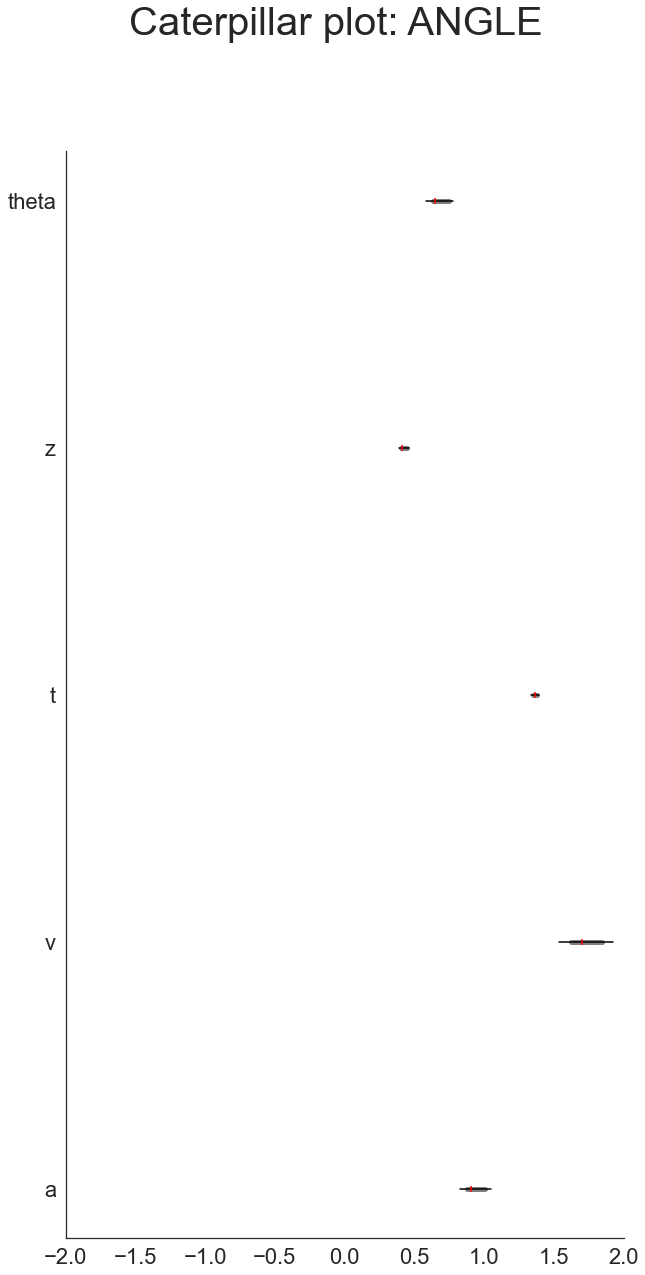

In [43]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model.get_traces(),
                 ground_truths = params.values[0],
                 model = model,
                 datatype = 'single_subject',
                 drop_sd = True)

### Posterior Predictive
Another way to examine whether or not our recovery was satisfactory is to perform posterior predictive checks. Essentially, we are looking to simulate datasets from the trace and check whether it aligns with the ground truth participant data. This answers the question of whether or not these parameters that you recovered can actually reproduce the data. Note that the parameter ``n_post_params`` controls the number of samples drawn from the trace. Here we draw randomly 200 (out of 1200).

In [ ]:
# Posterior Predictive: Do we generate meaningful data from the Posterior Model?
posterior_predictive_plot(ground_truths_parameters = params.values[0],
                          ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1),
                          posterior_samples = hddm_model.get_traces(),
                          model_gt = None,
                          model_fitted = model,
                          n_post_params = 100,
                          n_plots = 1,
                          max_t = 5, 
                          input_hddm_trace = True,
                          datatype = 'single_subject',
                          hist_linewidth = 3)

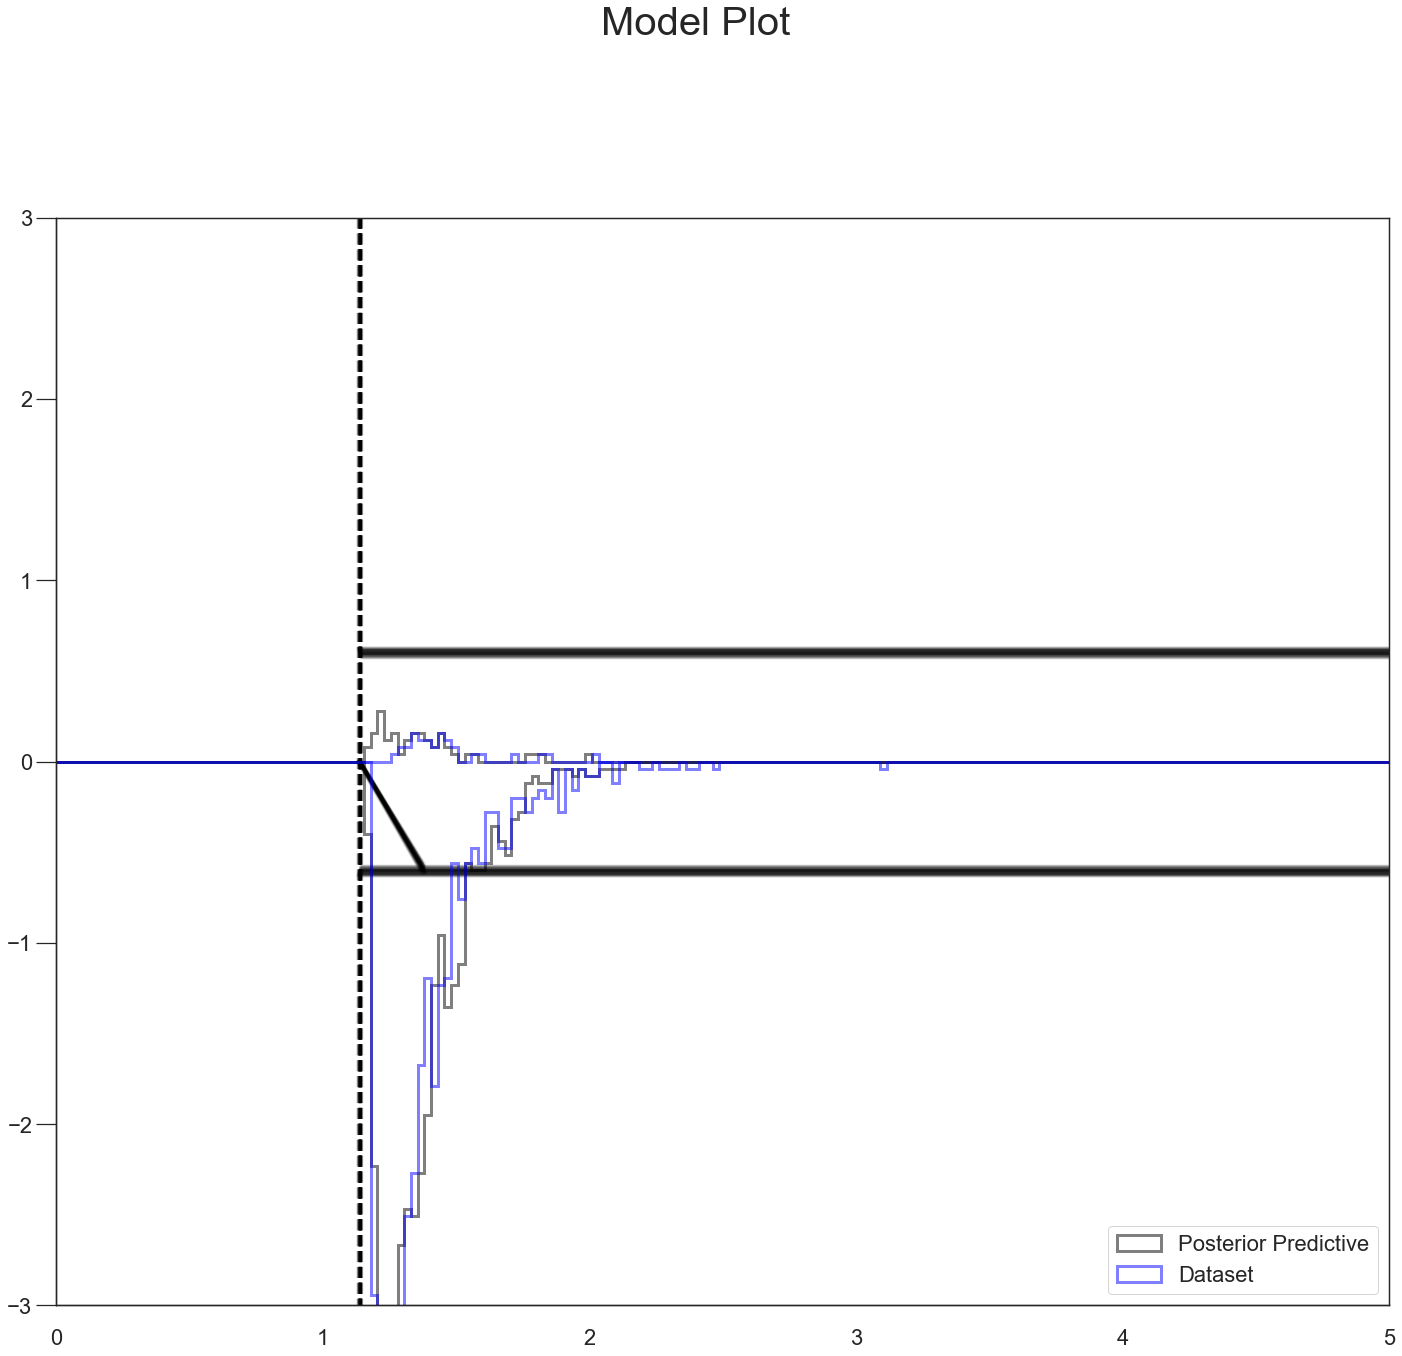

In [8]:
# Posterior Predictive: Do we generate meaningful data from the Posterior Model?
model_plot(ground_truths_parameters = None,
           ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1),
           posterior_samples = hddm_model.get_traces(),
           model_gt = None,
           model_fitted = model,
           n_post_params = 100,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject',
           ylimit = 3,
           posterior_linewidth = 3,
           gt_linewidth = 3,
           hist_linewidth = 3,)

### Note

Above we used the model plot with *empirical data*, which is signified in <span style="color:blue"> **blue** </span>. Empirical data doesn't have a *true* model of course, so we don't see a *don't* see a <span style="color:blue"> **blue** </span> model caricature here, but simply our posterior model parameterizations.

### A small note on convergence

Note that the MCMC algorithm requires the chain to converge. There are many heuristics that help you identifying problems with convergence, such as the trace plot, auto correlation plot, and marginal posterior histogram. In the trace plots, there might be a problem if you see large jumps. In the autocorrelation plot, there might be a problem if it does not drop rapidly. The `HDDMnn()` classes support the computation of the *Gelman-Rubin*, *r-hat* statistic, as you would with any `hddm` model. Generally, by extracting the traces, you are free to compute any convergence statistics you want of course. 

Plotting a
Plotting v
Plotting t
Plotting z
Plotting theta


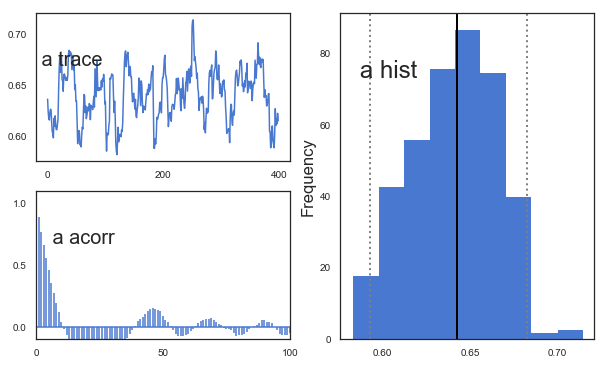

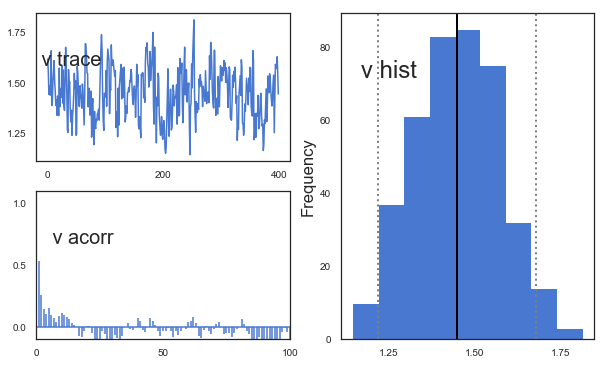

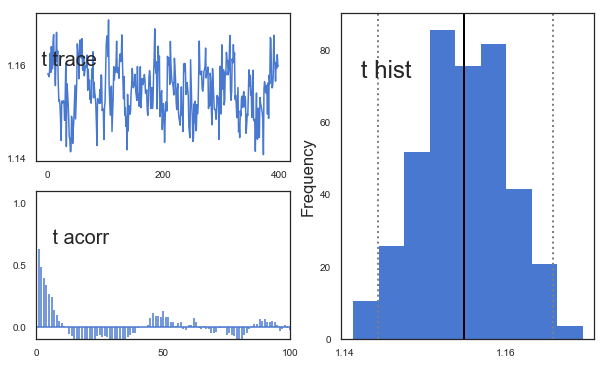

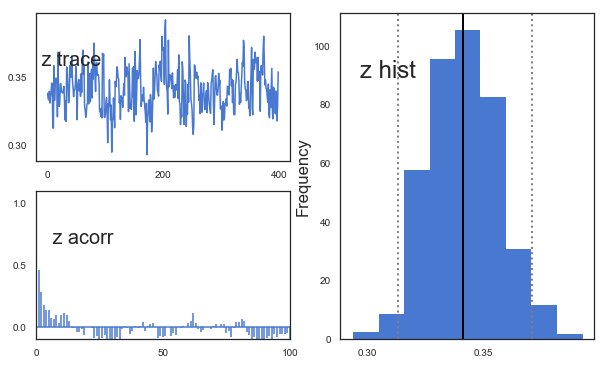

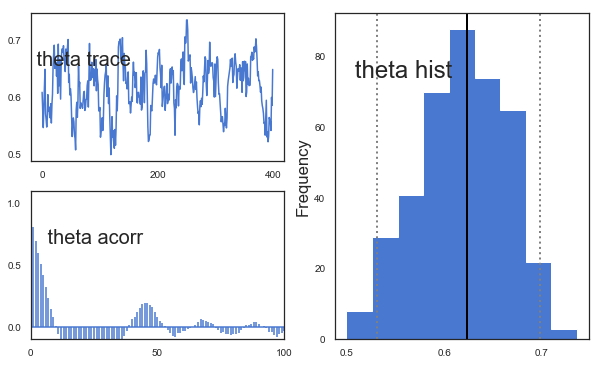

In [35]:
# TAKING A LOOK AT THE POSTERIOR TRACES
hddm_model_single_subject.plot_posteriors(['a', 't', 'v', 'z', 'theta'])

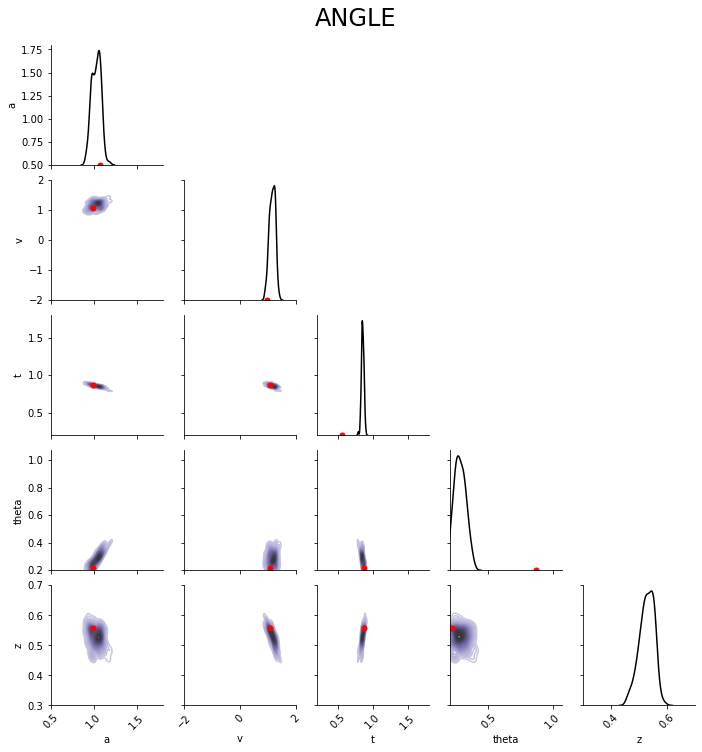

In [10]:
# Pairwise posterior plot
posterior_pair_plot(posterior_samples = hddm_model.get_traces(),
                    height = 10,
                    aspect = 1,
                    n_subsample = 200,
                    ground_truths = params.values[0],
                    model = model)

In [13]:
hddm_model.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.0294,0.0527197,0.93881,0.988086,1.02896,1.0694,1.12931,0.00488268
v,1.15964,0.101028,0.96933,1.08761,1.16006,1.23668,1.35366,0.00815114
t,0.85648,0.0188871,0.820278,0.845079,0.857037,0.869895,0.891777,0.00173543
z,0.528634,0.025416,0.4751,0.509546,0.530362,0.548453,0.573562,0.00222707
theta,0.278943,0.0479883,0.189506,0.245137,0.279523,0.311806,0.364347,0.00411922


Ideally we would want to simulate a dataset from scratch and fitting it. The code to do so, is commented out above. However, due to time constraints, we will sometimes load in a dataset, its ground truth parameter and its trace. Note that the ``pickle`` is a tuple of:

0. The trace
1. Ground truth parameter
2. Dataset

# SECTION 3: HIERARCHICAL MODELS

The 'h' in `hddm` stands for hierarchical, so let's do it! If we have data from multiple participants and we assume that the parameters of single participants are drawn from respective **group** or **global** distributions, we can model this explicitly in `hddm` by specifying `is_group_model = True`.

Implicitly we are fitting a model of the following kind,

$$p(\{\theta_j\}, \{\theta_g\} | \mathbf{x}) \propto \left[ \prod_j^{J} \left[ \prod_i^{N_j} p(x_i^j | \theta_j) \right] p(\theta_j | \theta_g) \right] p( \theta_g | \theta_h )$$

where (let's say for the **angle model**),
1. $\theta_j = \{v_j, a_j, z_j, t_j, \theta_j \}$, are the model parameters for **subject j**.

2. $\theta_g = \{v_g^{\mu}, a_g^{\mu}, z_g^{\mu}, t_g^{\mu}, \theta_g^{\mu}, v_g^{\sigma}, a_g^{\sigma}, z_g^{\sigma}, t_g^{\sigma}, \theta_g^{\sigma} \}$ (scary, but for completeness), are the **mean** and **variance** parameters for our group level normal distributions, and $\{ \theta_h \}$ are **fixed hyperparameters**.

3. $x_i^j = \{rt_i^j, c_i^j \}$, are the **choice and reaction time**  of **subject j** during **trial i**.

In words, the right hand side of the equation tells us that we have a **global parameter distribution** with certain **means** and **variances** for each parameter (we want to figure these means and variances out), from which the **subject level parameters** are drawn and finally **subject level datapoints** follow the likelihood distribution of our **ddm / angle / weibull / you name it** mdoels.

In [19]:
# Metadata
nmcmc = 300
model = 'angle'
n_samples_by_subject = 500
n_subjects = 5
includes = hddm_include_config[model]
p_outlier = [] # empty of ['p_outlier']
includes += p_outlier

In [19]:
# Simulate data angle
hddm_data_hierarchical, gt_hierarchical, gt_mat_hierarchical = simulator_hierarchical(n_subjects = n_subjects,
                                                                                      model = model,
                                                                                      n_samples_by_subject = n_samples_by_subject)

In [25]:
hddm_model = hddm.HDDMnn(hddm_data_hierarchical, 
                         model = model,
                         informative = False,
                         include = includes, #is_group_model = True,
                         p_outlier = 0.0)

Recognized HDDMnn
RT
0.40609077
2.1463556
Response
[-1.  1.]
knodes
OrderedDict([('a', a), ('a_std', a_std), ('a_tau', a_tau), ('a_bottom', a_subj), ('v', v), ('v_std', v_std), ('v_tau', v_tau), ('v_bottom', v_subj), ('t', t), ('t_std', t_std), ('t_tau', t_tau), ('t_bottom', t_subj), ('z_trans', z_trans), ('z', z), ('z_std', z_std), ('z_tau', z_tau), ('z_subj_trans', z_subj_trans), ('z_bottom', z_subj), ('theta', theta), ('theta_std', theta_std), ('theta_tau', theta_tau), ('theta_bottom', theta_subj)])
wfpt parents: 
OrderedDict([('a', a_subj), ('v', v_subj), ('t', t_subj), ('z', z_subj), ('p_outlier', 0.0), ('w_outlier', 0.1), ('theta', theta_subj)])
0.0


In [26]:
# # Sampling:
hddm_model.sample(nmcmc,
                  burn = 100)

 [-----------------100%-----------------] 300 of 300 complete in 50.6 sec

In [27]:
# Sample
hddm_model.get_traces()

,a,a_std,a_subj.000,a_subj.001,a_subj.002,a_subj.003,a_subj.004,v,v_std,v_subj.000,...,z_subj_trans.002,z_subj_trans.003,z_subj_trans.004,theta,theta_std,theta_subj.000,theta_subj.001,theta_subj.002,theta_subj.003,theta_subj.004
0,0.761531,0.060103,0.751410,0.792187,0.707500,0.856754,0.707880,0.325324,0.670304,0.189323,...,0.306155,0.371479,0.372354,0.374927,0.091413,0.367084,0.343558,0.411931,0.275368,0.449221
1,0.775406,0.053934,0.754141,0.795954,0.688765,0.835635,0.684770,0.459713,0.365114,0.026127,...,0.257205,0.313482,0.408294,0.340119,0.074997,0.371771,0.331169,0.368872,0.270660,0.394748
2,0.765635,0.058964,0.756366,0.793306,0.685939,0.811593,0.660020,1.628743,1.315852,-0.009996,...,0.316510,0.316735,0.328962,0.320176,0.043049,0.384300,0.323292,0.374689,0.272400,0.365089
3,0.733304,0.060579,0.765841,0.808340,0.666270,0.796888,0.649351,0.750918,0.988920,0.217499,...,0.345120,0.331684,0.322592,0.306618,0.115148,0.364834,0.371358,0.345284,0.239769,0.297708
4,0.725495,0.085588,0.766483,0.811562,0.671245,0.811202,0.636648,0.811957,0.192467,0.192391,...,0.353279,0.306763,0.376260,0.271722,0.143562,0.383212,0.384443,0.363121,0.230145,0.286015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.690443,0.088738,0.795574,0.788592,0.710225,0.793042,0.699056,0.983987,0.156773,0.315041,...,0.450821,0.206090,0.511890,0.519963,0.639137,0.416749,0.333625,0.434208,0.180108,0.454416
196,0.733950,0.066654,0.790488,0.787785,0.715082,0.792928,0.685117,0.975393,0.378100,0.218595,...,0.391692,0.224428,0.452391,0.113139,0.315234,0.370000,0.329034,0.401416,0.209230,0.458807
197,0.649802,0.184506,0.723981,0.775737,0.687897,0.797794,0.674336,0.756007,0.458069,0.144972,...,0.325104,0.290424,0.367467,0.247574,0.543317,0.321827,0.352331,0.409623,0.172131,0.422047
198,0.619473,0.258896,0.735165,0.809928,0.714222,0.787869,0.670142,0.567176,0.424810,0.148530,...,0.337007,0.266463,0.332946,0.394875,0.208833,0.302767,0.361047,0.425355,0.166727,0.378793


/Users/afengler/OneDrive/git_repos/hddmnn_tutorial/helper_functions.py:1527: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  frameon = False)


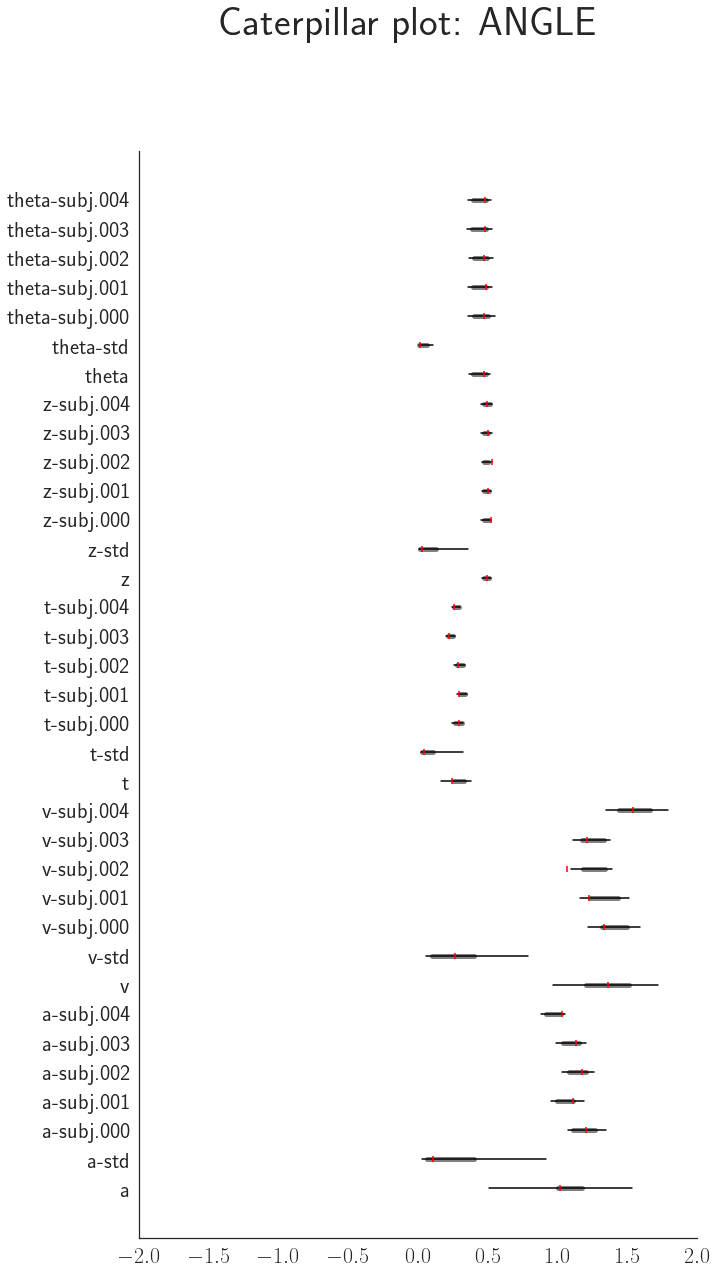

In [27]:
# Caterpillar Plot
caterpillar_plot(posterior_samples = hddm_model.get_traces(),
                 ground_truths = gt_hierarchical,
                 model = model,
                 datatype = 'hierarchical',
                 x_lims = [-2, 2],
                 aspect_ratio = 2,
                 drop_sd = False,
                 save = False)

(5, 200, 5)


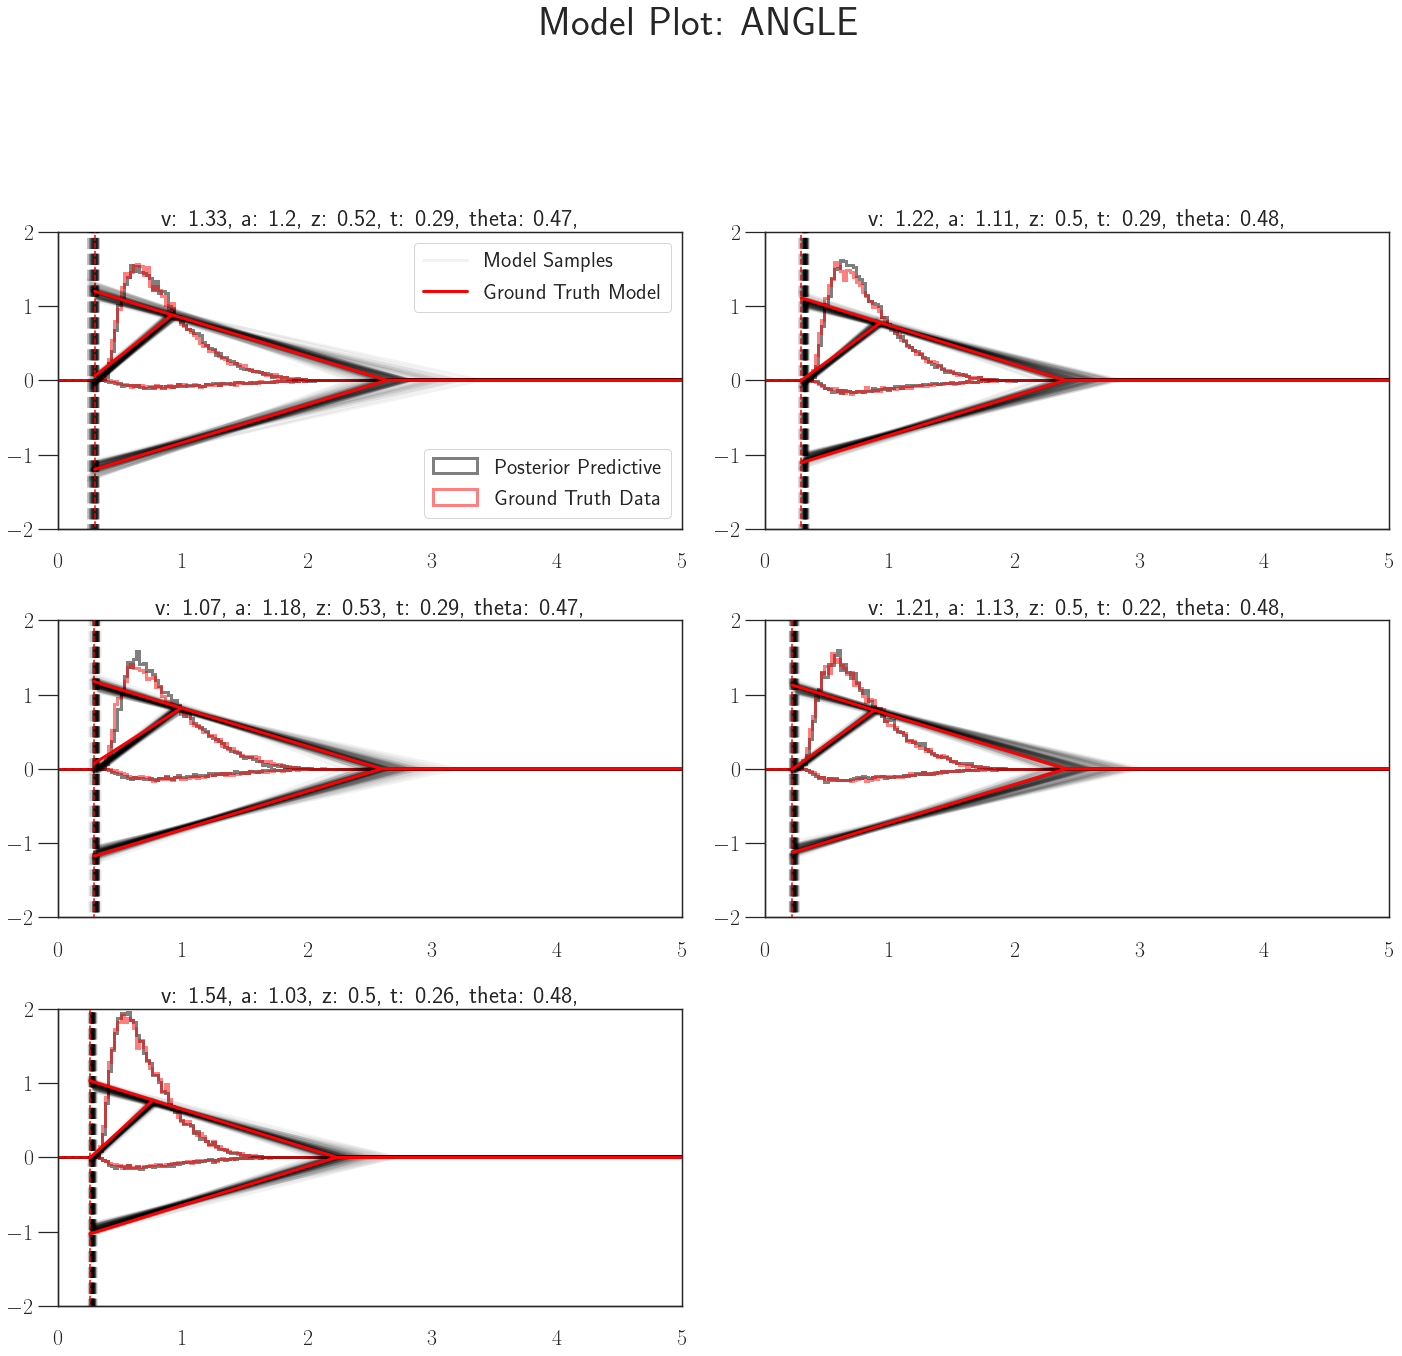

In [29]:
# Posterior Predictive
model_plot(ground_truths_parameters = gt_mat_hierarchical,
           posterior_samples = hddm_model.get_traces(),
           ground_truths_data = None,
           input_hddm_trace = True,
           n_post_params = 100,
           samples_by_param = 200,
           cols = 2,
           model_gt = model,
           model_fitted = model,
           datatype = 'hierarchical',
           n_plots = 10,
           max_t = 5,
           show_model = True,
           save = False)

# SECTION 4: PARAMETER VARIES BY CONDITION

An important aspect of these posterior analysis, is the consideration of experiment design.
We may have an experiment in which subject are exposed to a variety of conditions, 
such as for example different degrees of difficulty of the same task

It is often reasonable to assume that all but the conceptually relevant parameters are common across conditions.

As a by-product, such experiment designs can help us with the recovery of the constant parameters, by probing those static aspects of the model across varying kinds of datasets (driven by targeted manipulation of variable aspects of the model).

Implicitly we fit the following kind of model,

$$p( \{\theta_c \}, \theta | \mathbf{x} ) \propto  \left[ \prod_c^C  \left[ \prod_i^{N_i} p( x_i^c | \theta_c, \theta ) \right] p(\theta_c)  \right] p(\theta)$$


Where $\theta_c$ is the condition dependent part of the parameter space, and $\theta$ forms the portion of parameters which remain constant across condtions. 

To give a more concrete example involving the **weibull model** (executed below), consider a dataset for a single participant, who went through four conditions of an experiment. Think of the conditions as manipulating the payoff structure of the experiment to incentivize / disincentivize accuracy in favor of speed. We operationalize this by treating the $a$ parameter, the initial boundary separation, as affected by the manipulation, while the rest of the parameters are constant across all experiment conditions.

The resulting model would be of the form, 

$$ p( {a_c}, v, z, t, \alpha, \beta | x ) \propto \left[ \prod_c^C  \left[ \prod_i^{N_c} p( x_i^c | a_c, v, z, t, \alpha, \beta)  \right] p(a_c) \right]  p(v, z, t, \alpha, \beta)$$ 

In [20]:
# Metadata
nmcmc = 300
model = 'weibull_cdf'
n_samples_by_condition = 500
n_conditions = 5
includes = hddm_include_config[model]
p_outlier = [] # empty of ['p_outlier']
includes += p_outlier

In [21]:
# Generating some data
# We generate data such that only one parameter varies by condition (in this case 'a' --> the initial boundary separation)
hddm_data_condition, gt_condition, gt_mat_condition = simulator_condition_effects(n_conditions = n_conditions, 
                                                                                  n_samples_by_condition = n_samples_by_condition,
                                                                                  condition_effect_on_param = ['a'], 
                                                                                  model = model,
                                                                                  )

In [22]:
hddm_data_condition.head()

,rt,response,nn_response,condition
0,2.365558,1,1,0
1,2.673572,0,-1,0
2,1.888539,1,1,0
3,1.134548,0,-1,0
4,2.152548,0,-1,0


In [23]:
# Ground Truth Parameters
gt_condition

{'a(0)': 1.1905528029409598,
 'a(1)': 1.4469147075699214,
 'a(2)': 1.4917768414676829,
 'a(3)': 1.190011055934507,
 'a(4)': 0.7887930482783626,
 'v': -0.23896622471850248,
 'z': 0.42688928889583333,
 't': 0.9475476149776518,
 'alpha': 1.3554239319599313,
 'beta': 4.021382929167153}

In [24]:
# Make HDDM Model 
hddm_model = hddm.HDDMnn(hddm_data_condition, 
                         model = model,
                         informative = False,
                         include = includes,
                         p_outlier = 0.0,
                         is_group_model = False, 
                         depends_on = {'a': 'condition'})

Now adding the HDDMBase include:
Include from inside HDDMBase:  {'a', 't', 'v'}
Recognized HDDMnn
RT
0.99854755
4.8854446
Response
[-1.  1.]
knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('alpha_bottom', alpha), ('beta_bottom', beta)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('z', z), ('p_outlier', 0.0), ('w_outlier', 0.1), ('alpha', alpha), ('beta', beta)])
Is Neural Net?  True
0.0


In [25]:
# Sample
hddm_model.sample(nmcmc, burn = 100)

 [-----------------100%-----------------] 300 of 300 complete in 43.9 sec

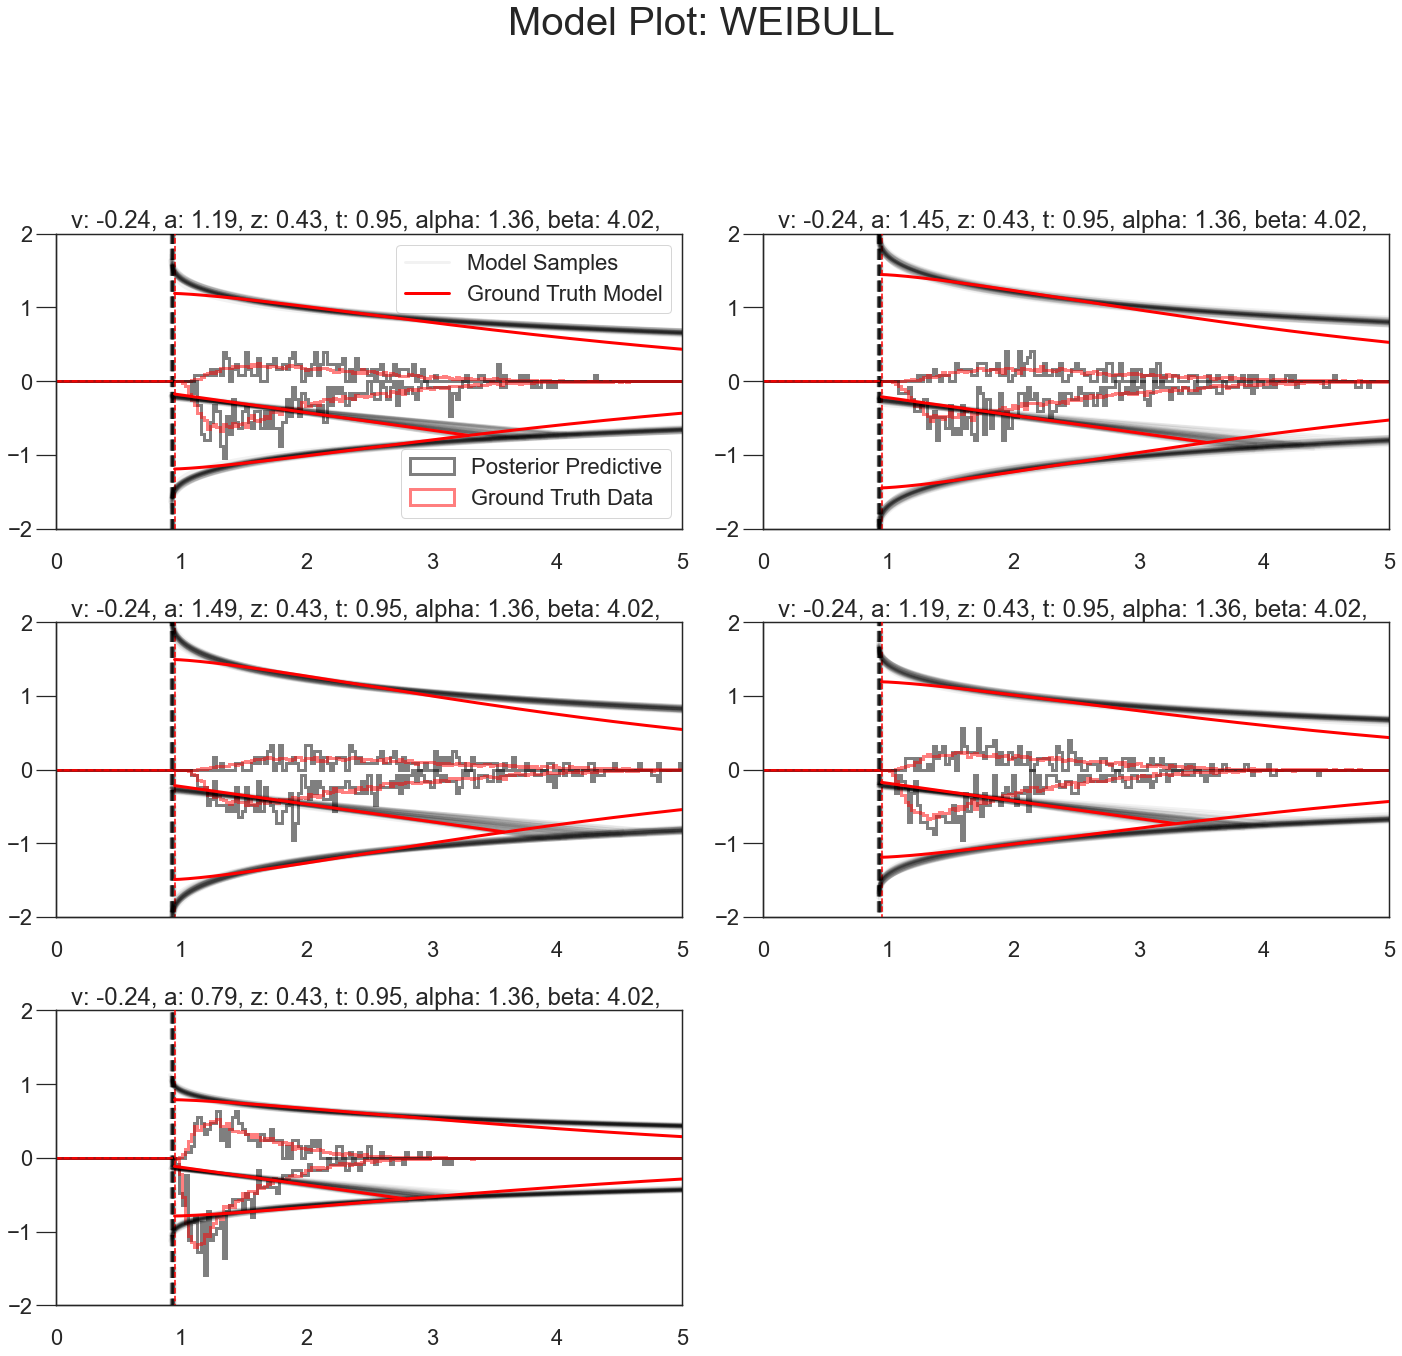

In [26]:
model_plot(posterior_samples = hddm_model.get_traces(),
           ground_truths_parameters = gt_mat_condition,
           ground_truths_data = None,
           model_gt = model,
           model_fitted = model,
           datatype = 'condition',
           input_hddm_trace = True,
           n_post_params = 50,
           n_plots = 4,
           cols = 2,
           show_model = True)

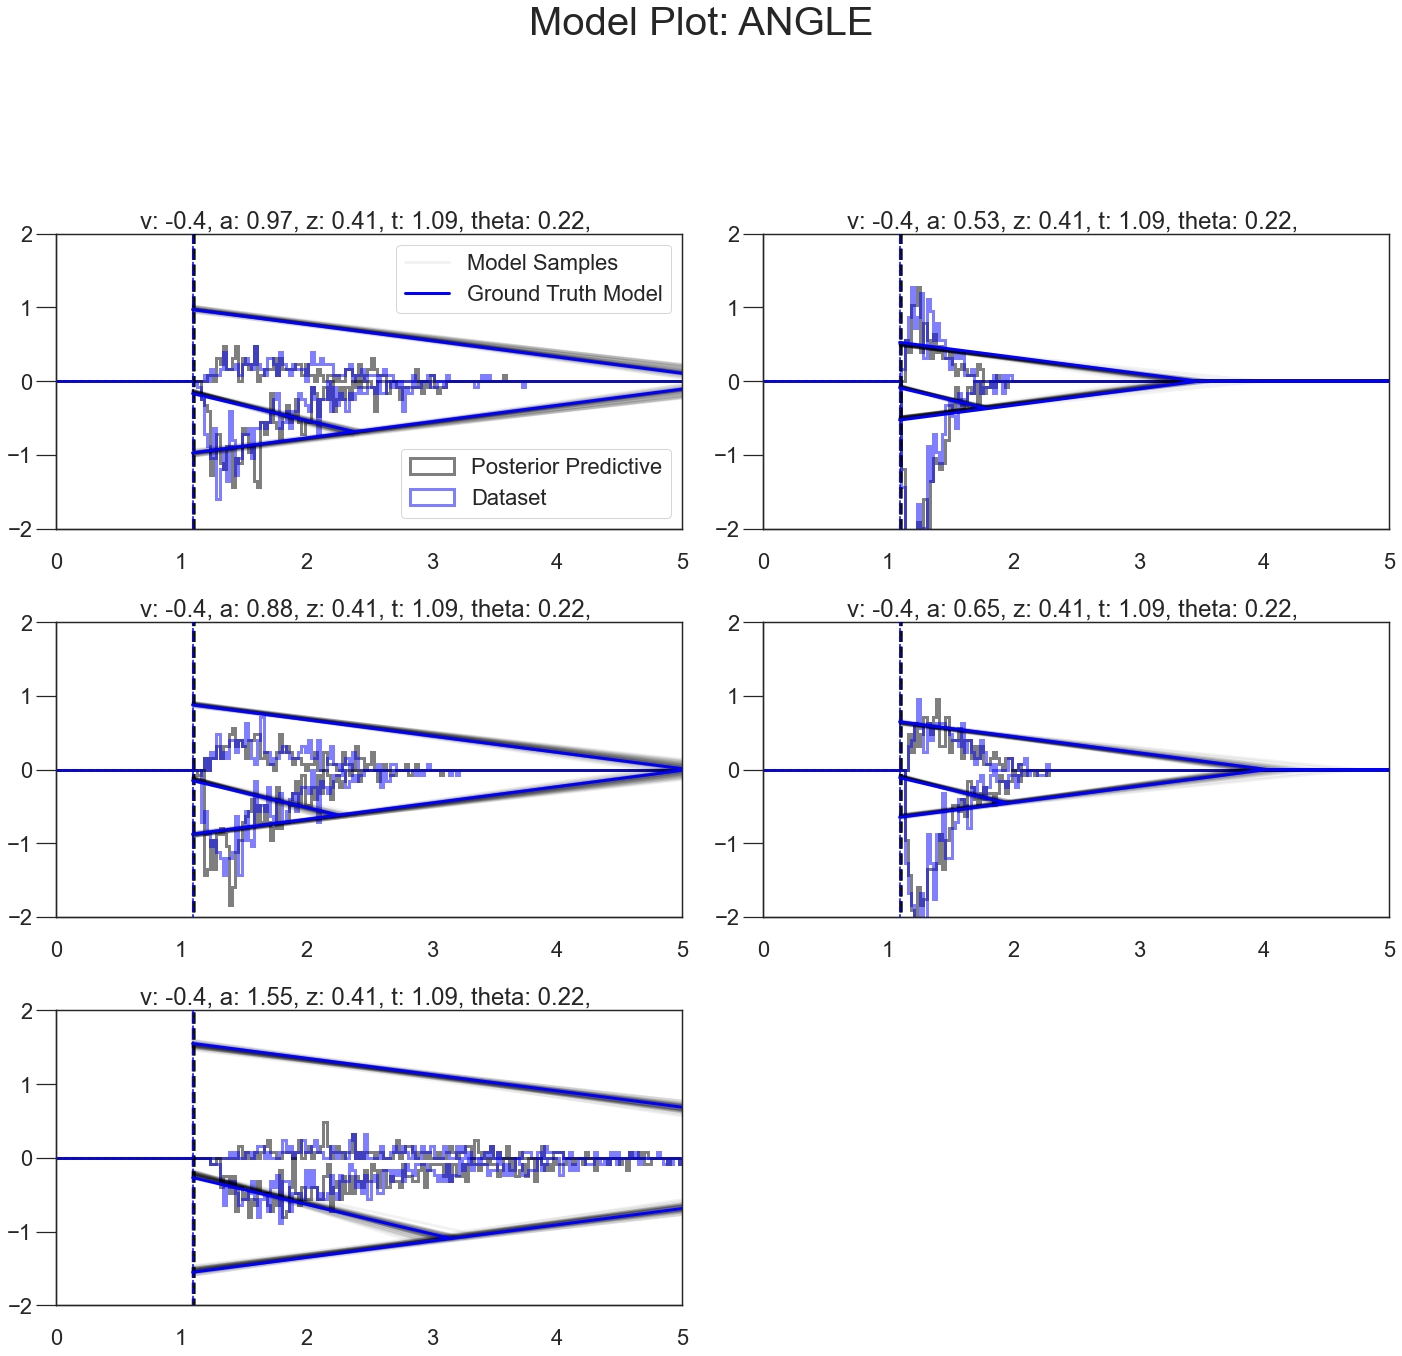

In [10]:
model_plot(posterior_samples = hddm_model.get_traces(),
           ground_truths_parameters = gt_mat_condition,
           ground_truths_data = hddm_data_condition,
           model_gt = model,
           model_fitted = model,
           datatype = 'condition',
           input_hddm_trace = True,
           n_post_params = 50,
           n_plots = 4,
           cols = 2,
           show_model = True)

# SECTION 5: REGRESSORS

This section provides a simple working example using the Neural Networks with the Regression backend.
The regression back-end allows linking parameters to trial-by-trial covariates via a (general) linear model.

In [2]:
# Metadata
nmcmc = 1000
model = 'angle'
n_samples = 100
includes = hddm_include_config[model]
p_outlier = [] # empty of ['p_outlier']
includes += p_outlier

In [3]:
# Generate some basic simulations
params =  make_parameter_sets(model = model,
                              n_parameter_sets = 1)

simulations = simulator(theta = params.values[0],
                        model = model, 
                        n_samples = n_samples)

hddm_data_single_subject_regress = hddm_preprocess(simulations)

In [4]:
simulations = simulator_covariate(dependent_params = ['v'],
                                  model = model,
                                  n_samples = n_samples,
                                  beta = 0.1,
                                  subj_id = 'none')

In [5]:
# Mean parameters
simulations[1].mean(axis = 0)

array([-0.70268446,  1.00567771,  0.32077411,  1.76071292,  0.8318902 ])

In [6]:
# Set up the regressor a regressor:

v_reg = {'model': 'v ~ 1 + BOLD', 'link_func': lambda x: x}
#a_reg = {'model': 'a ~ 1 + BOLD', 'link_func': lambda x: x}
#t_reg = {'model': 't ~ 1 + BOLD', 'link_func': lambda x: x}
#g_reg = {'model': 'a ~ 1 + BOLD', 'link_func': lambda x: x}

reg_descr = [v_reg] #[v_reg, a_reg, t_reg, g_reg] # theta_reg]

In [7]:
# Make HDDM model
hddm_reg = hddm.HDDMnnRegressor(simulations[0], 
                                reg_descr, 
                                include = set(hddm_include_config[model]),
                                informative = False,
                                p_outlier = 0.0,
                                model = model)

outcomes:  v
Adding these covariates:
['v_Intercept', 'v_BOLD']
Now adding the HDDMBase include:
Include from inside HDDMBase:  {'t', 'v', 'a'}
Recognized HDDMnn
RT
1.7977128
2.4387078
Response
[-1.  1.]
Printing reg outcome:
{'v'}
{'t', 'theta', 'z', 'a'}
knodes
OrderedDict([('a_bottom', a), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('theta_bottom', theta)])
knodes
OrderedDict([('a_bottom', a), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('theta_bottom', theta)])
reg:  {'outcome': 'v', 'model': ' 1 + BOLD', 'params': ['v_Intercept', 'v_BOLD'], 'link_func': <function <lambda> at 0x11160e8c0>}
param_lookup passed to _create stochastic_knodes
v
['v']
knodes
OrderedDict([('v_bottom', v)])
OrderedDict([('v_bottom', v)])
name:  v_bottom
names:  ['v_bottom']
v_reg
wfpt parents: 
OrderedDict([('a', a), ('v', v_reg), ('t', t), ('z', z), ('p_outlier', 0.0), ('w_outlier', 0.1), ('theta', theta)])
Is Neural Net?  True


In [8]:
# Sample
hddm_reg.sample(1000, burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 126.0 sec

In [9]:
# Posterior Stats
hddm_reg.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.29073,0.187712,0.994066,1.16162,1.26447,1.4173,1.69322,0.0174183
t,0.461951,0.0696979,0.30402,0.426154,0.472021,0.51039,0.56921,0.00617938
z,0.453996,0.0378227,0.383592,0.425821,0.452931,0.480498,0.530028,0.00219175
theta,0.506483,0.104762,0.291277,0.442033,0.505752,0.585424,0.692472,0.00932779
v_Intercept,0.683791,0.175938,0.338575,0.560451,0.688151,0.8081,1.03262,0.00946796
v_BOLD,0.120337,0.204209,-0.274429,-0.0171828,0.121809,0.260378,0.509231,0.00671858


# SECTION 6: STIM CODING

In [2]:
# Metadata
nmcmc = 500
model = 'ddm'
n_samples_by_condition = 500
split_param = 'z'
includes = hddm_include_config[model]
p_outlier = [] # empty of ['p_outlier']
includes += p_outlier

In [3]:
hddm_data_stimcoding_single_subject = simulator_stimcoding(model = model,
                                                           split_by = split_param,
                                                           n_samples_by_condition = n_samples_by_condition)

In [4]:
hddm_data_stimcoding_single_subject

(           rt  response  nn_response  stim
 0    2.323564         1            1     1
 1    2.902565         1            1     1
 2    3.784603         1            1     1
 3    2.634560         1            1     1
 4    2.881564         1            1     1
 ..        ...       ...          ...   ...
 495  2.014567         1            1     2
 496  2.194565         1            1     2
 497  2.324564         1            1     2
 498  2.054567         1            1     2
 499  1.901567         1            1     2
 
 [1000 rows x 4 columns],
 {'z': 0.30457714747064546, 'decision_criterion': 0.0},
 array([[1.81899542, 1.38928275, 0.30457715, 1.75656723],
        [1.81899542, 1.38928275, 0.69542285, 1.75656723]]))

In [5]:
hddm_model = hddm.HDDMnnStimCoding(hddm_data_stimcoding_single_subject[0],
                                   include = includes,
                                   model = model,
                                   stim_col = 'stim',
                                   p_outlier = 0.0,
                                   split_param = split_param)

['z']
Setting model to be non-informative
passing through here...
Adding z to includes.
Now adding the HDDMBase include:
Include from inside HDDMBase:  {'t', 'a', 'v'}
Recognized HDDMnn
RT
1.6563728
5.342278
Response
[-1.  1.]
odict_keys(['a_bottom', 'v_bottom', 't_bottom', 'z_trans', 'z_bottom'])
knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('z', z), ('p_outlier', 0.0), ('w_outlier', 0.1)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('z', z), ('p_outlier', 0.0), ('w_outlier', 0.1)])
wfpt parents in _create_wfpt_knode OrderedDict([('a', a), ('v', v), ('t', t), ('z', z), ('p_outlier', 0.0), ('w_outlier', 0.1)])
Is Neural Net?  True
0.0


In [6]:
hddm_model.sample(nmcmc, burn = 100)

 [-----------------100%-----------------] 500 of 500 complete in 20.7 sec

In [7]:
hddm_model.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,0.988279,0.0337842,0.932432,0.961433,0.987503,1.01057,1.05259,0.00309442
v,1.46563,0.0491325,1.36649,1.43317,1.46484,1.49847,1.55693,0.00274043
t,1.16429,0.00853288,1.14672,1.15814,1.1649,1.17071,1.1793,0.000737317
z,0.381504,0.008591,0.363502,0.377079,0.381604,0.386777,0.398371,0.000512323
theta,0.2892,0.0378291,0.214919,0.263198,0.289471,0.31687,0.35852,0.00321505


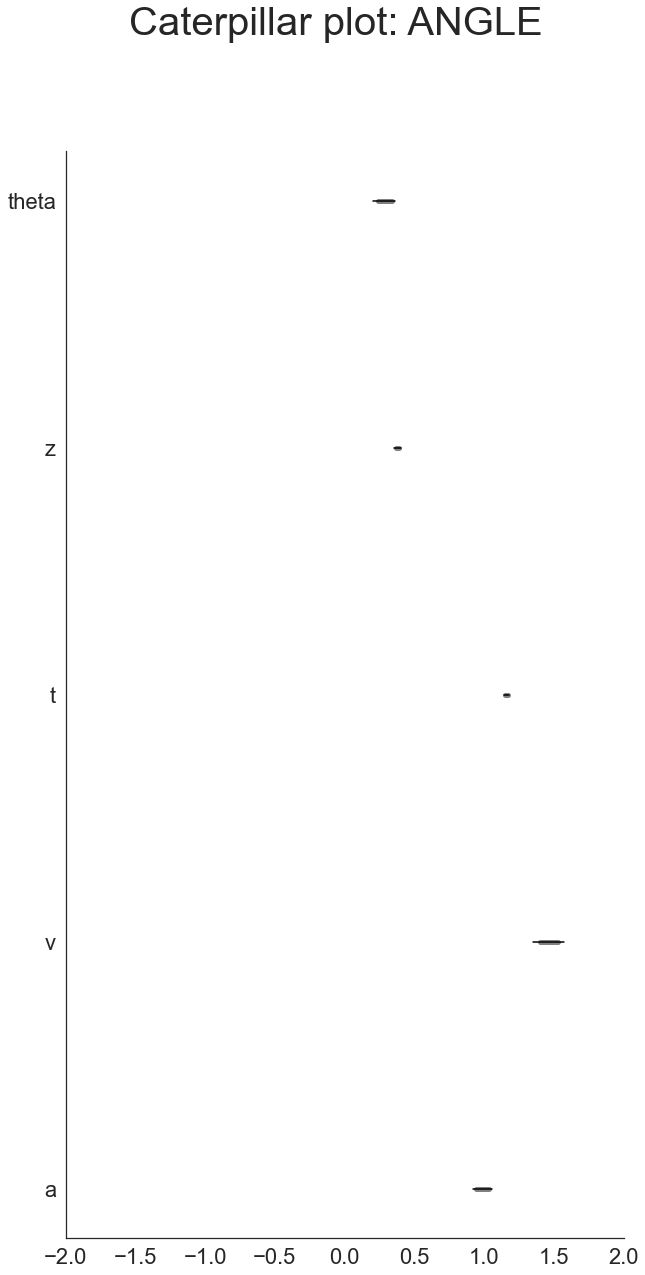

In [30]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model.get_traces(),
                 ground_truths = None, #weibull_params.values[0],
                 model = model,
                 datatype = 'stimcoding',
                 drop_sd = True)

### NOTE: 

The `model_plot()`, `posterior_predictive_plot()`, and `caterpillar_plot()` functions still need to properly incorporate *stimcoding* data. This will be updated as soon as possible.

# SECTION 7: MODEL RECOVERY

Lastly we are going to look at model recovery, because it is tempting now that we have three kinds of models at our hands ( **ddm / angle / weibull **). 

For the little model recovery study we conduct here, we generate data from the **weibull** model and fit the data once each to the  **weibull**, **angle** and **ddm** models.

We inspect the fits visually and then use the *DIC* (Deviance information criterion, lower is better :)), to check if we can recover the **true** model. 

In [38]:
# Let's generate data from one of our three models
params = make_parameter_sets(model = 'weibull_cdf',
                                     n_parameter_sets = 1)

simulations = simulator(theta = params.values[0],
                        model = 'weibull_cdf', 
                        n_samples = 1000)

hddm_data_recov = hddm_preprocess(simulations)

In [40]:
# Now we fit for each model:
hddm_model_single_subject_weibull = hddm.HDDMnn(hddm_data_recov, 
                                                informative = False,
                                                model = 'weibull_cdf',
                                                p_outlier = 0.0,
                                                include = hddm_include_config['weibull_cdf'],
                                                is_group_model = False)

hddm_model_single_subject_angle = hddm.HDDMnn(hddm_data_recov, 
                                              model = 'angle',
                                              informative = False,
                                              p_outlier = 0.0,
                                              include = hddm_include_config['angle'],
                                              is_group_model = False)

hddm_model_single_subject_ddm = hddm.HDDMnn(hddm_data_recov, 
                                            informative = False, 
                                            model = 'ddm',
                                            p_outlier = 0.0,
                                            include = hddm_include_config['ddm'],
                                            is_group_model = False)

Recognized HDDMnn
RT
1.117863
4.558792
Response
[-1.  1.]
knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('alpha_bottom', alpha), ('beta_bottom', beta)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('z', z), ('p_outlier', 0.0), ('w_outlier', 0.1), ('alpha', alpha), ('beta', beta)])
0.0
Recognized HDDMnn
RT
1.117863
4.558792
Response
[-1.  1.]
knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('theta_bottom', theta)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('z', z), ('p_outlier', 0.0), ('w_outlier', 0.1), ('theta', theta)])
0.0
Recognized HDDMnn
RT
1.117863
4.558792
Response
[-1.  1.]
odict_keys(['a_bottom', 'v_bottom', 't_bottom', 'z_trans', 'z_bottom'])
knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('z', z), ('

In [41]:
nmcmc = 500
hddm_model_single_subject_weibull.sample(nmcmc, 
                                         burn = 200)

hddm_model_single_subject_angle.sample(nmcmc, 
                                       burn = 200)

hddm_model_single_subject_ddm.sample(nmcmc, 
                                     burn = 200)

 [-----------------100%-----------------] 500 of 500 complete in 15.5 sec

### CHECKING THE MODEL FITS VISUALLY

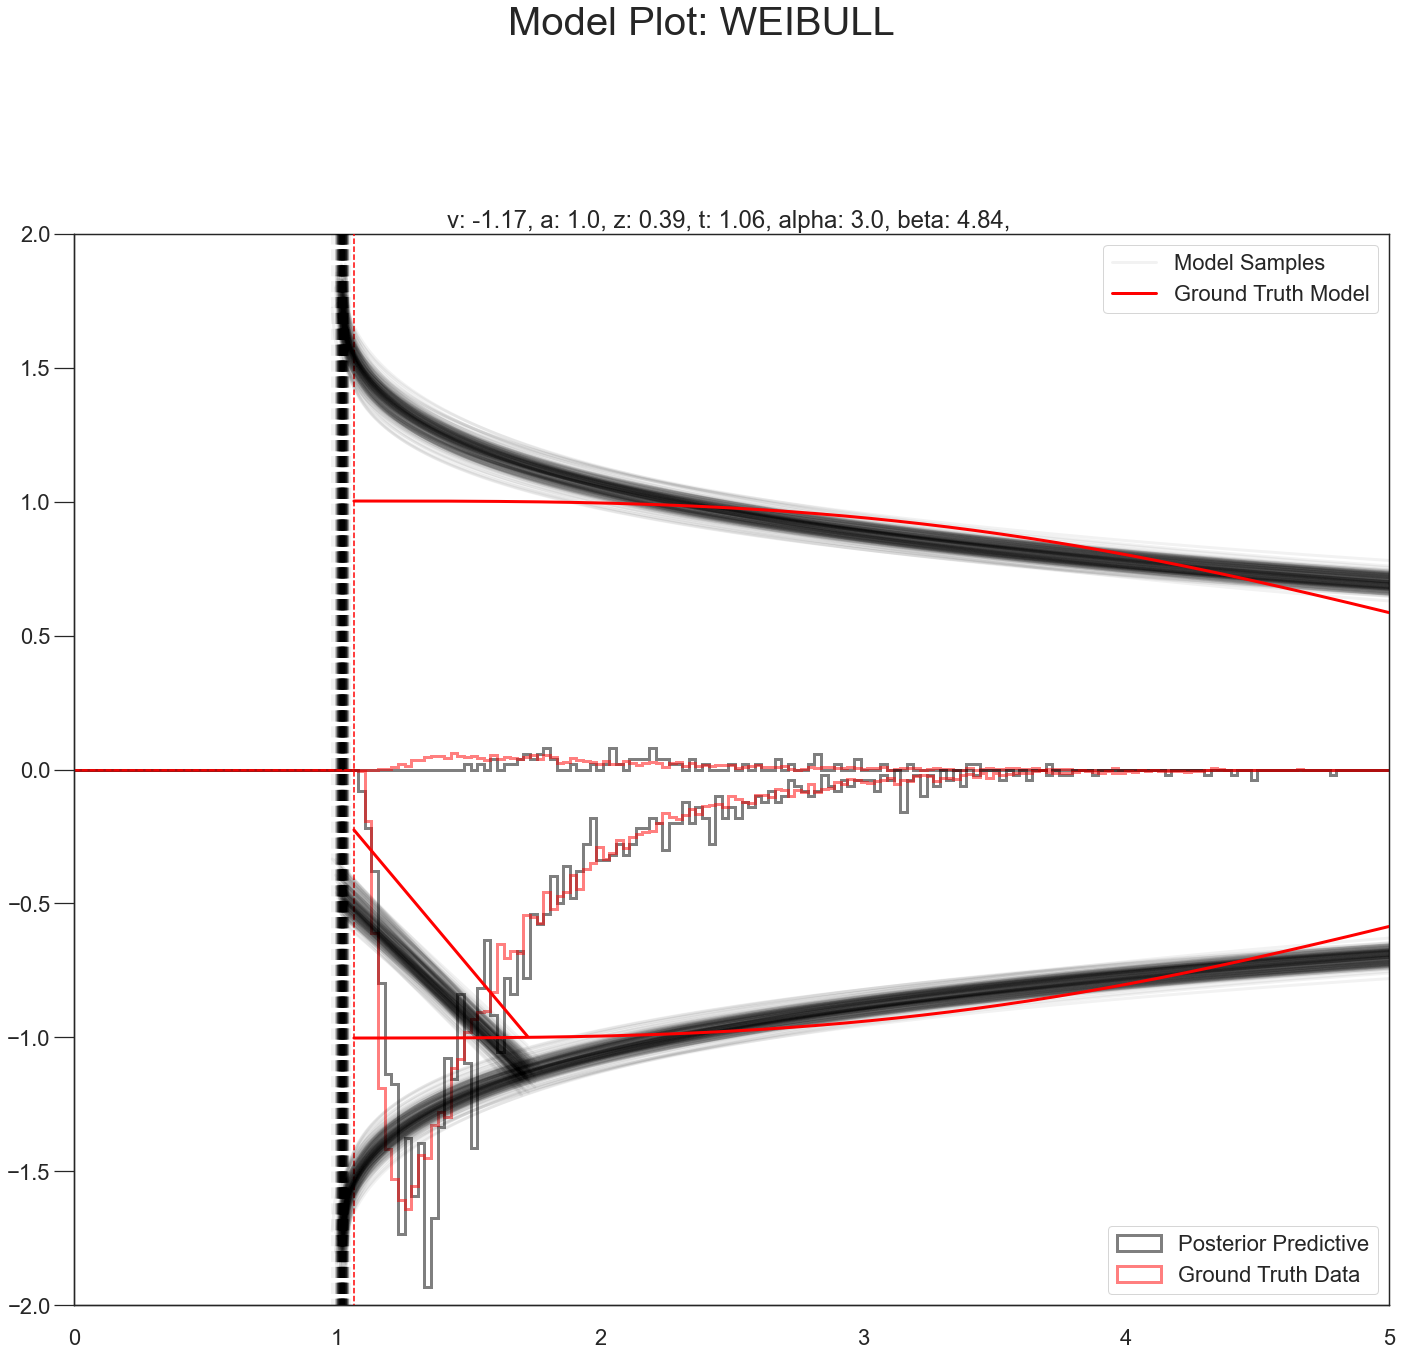

In [42]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths_parameters = params.values[0],
           posterior_samples = hddm_model_single_subject_weibull.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           n_post_params = 200,
           cols = 1,
           n_plots = 1,
           max_t = 5,
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

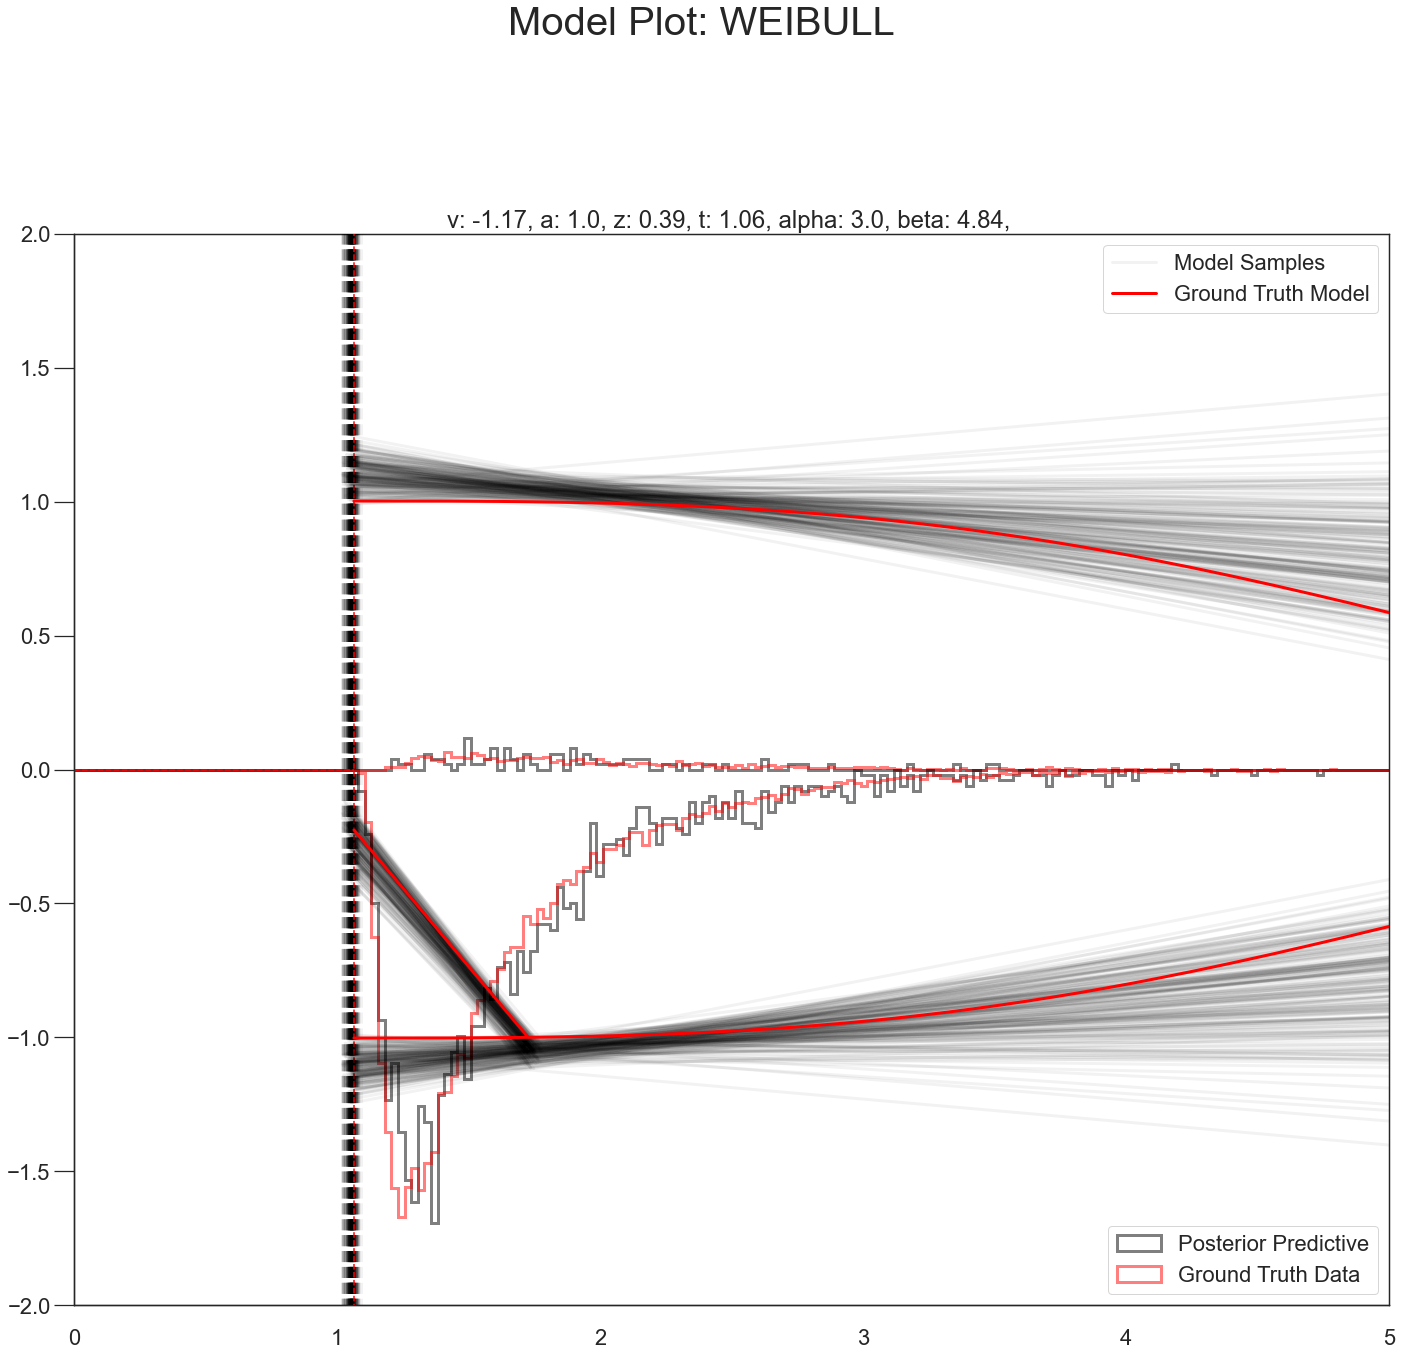

In [43]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths_parameters = params.values[0],
           posterior_samples = hddm_model_single_subject_angle.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'angle',
           n_post_params = 200,
           cols = 1,
           n_plots = 1,
           max_t = 5,
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

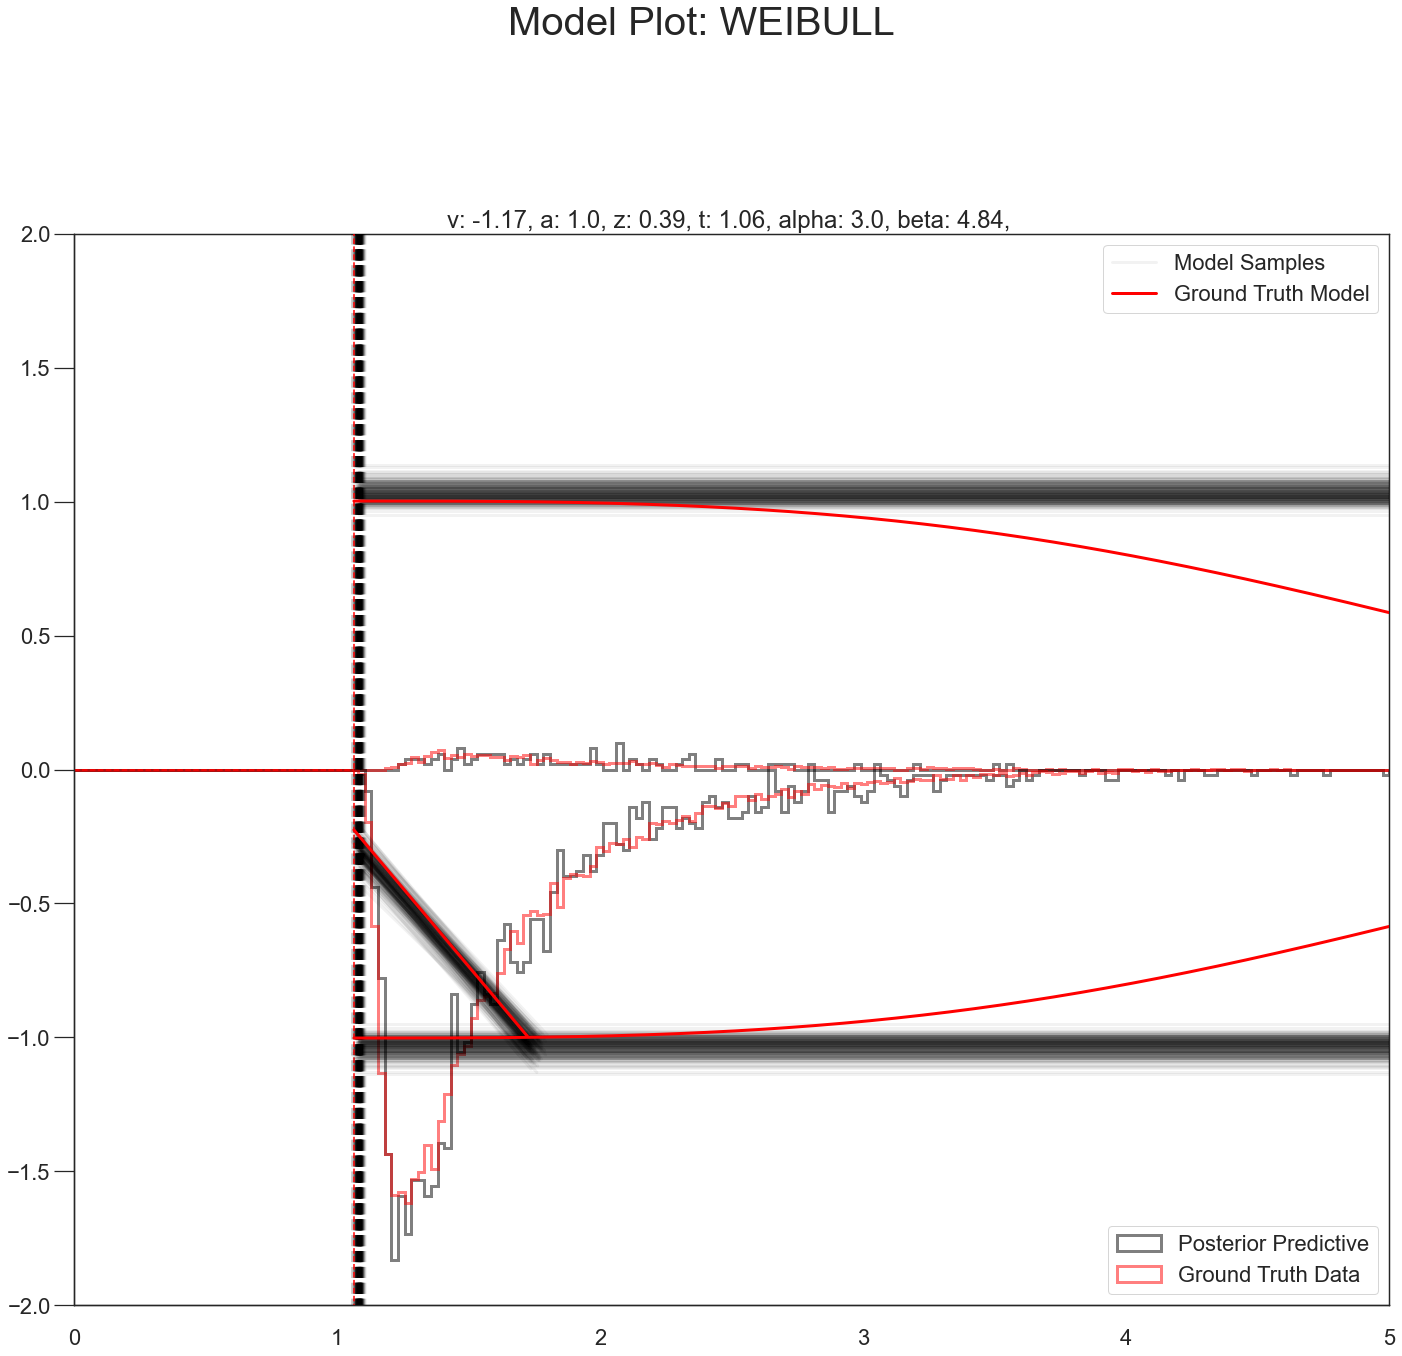

In [44]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths_parameters = params.values[0],
           posterior_samples = hddm_model_single_subject_ddm.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'ddm',
           n_post_params = 200,
           cols = 1,
           n_plots = 1,
           max_t = 5,
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

### Let's compare the DIC's 

In [45]:
hddm_model_single_subject_weibull.dic

1137.8225862630206

In [46]:
hddm_model_single_subject_angle.dic

1162.2813142903647

In [47]:
hddm_model_single_subject_ddm.dic

1164.1251888020834

**Fingers crossed** (this was a random run after all), the DIC usually gives us a result that conforms with the intuition we get from looking at the model plots. 

# SECTION 8: REAL DATA?

In [2]:
# Metadata
nmcmc = 100
burn = 50
model = 'angle'
n_samples_by_subject = 500
n_subjects = 5
includes = hddm_include_config[model]
p_outlier = [] # empty of ['p_outlier']
includes += p_outlier

#### Load and Pre-process dataset

In [3]:
# Load one of the datasets shipping with HDDM
cav_data = hddm.load_csv(hddm.__path__[0] + '/examples/cavanagh_theta_nn.csv')

In [4]:
cav_data

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.210,1.0,0.656275,1,HC
1,0,WL,1.630,1.0,-0.327889,1,LC
2,0,WW,1.030,1.0,-0.480285,1,HC
3,0,WL,2.770,1.0,1.927427,1,LC
4,0,WW,1.140,0.0,-0.213236,1,HC
...,...,...,...,...,...,...,...
3983,13,LL,1.450,0.0,-1.237166,0,HC
3984,13,WL,0.711,1.0,-0.377450,0,LC
3985,13,WL,0.784,1.0,-0.694194,0,LC
3986,13,LL,2.350,0.0,-0.546536,0,HC


In [5]:
# We overwrite the 'stim' column from ['LL', 'LW', 'WW'] to [0, 1, 2]
# for plotting

cond_dict = dict()
cnt = 0
for k in np.unique(cav_data['stim']):
    cond_dict[cnt] = k
    cnt += 1

tmp = np.zeros(cav_data.shape[0], dtype = np.int32)
for key in cond_dict.keys():
    tmp[cav_data['stim'] == cond_dict[key]] = int(key)
cav_data['stim'] = tmp

In [6]:
cav_data

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,0,1.210,1.0,0.656275,1,HC
1,0,1,1.630,1.0,-0.327889,1,LC
2,0,2,1.030,1.0,-0.480285,1,HC
3,0,1,2.770,1.0,1.927427,1,LC
4,0,2,1.140,0.0,-0.213236,1,HC
...,...,...,...,...,...,...,...
3983,13,0,1.450,0.0,-1.237166,0,HC
3984,13,1,0.711,1.0,-0.377450,0,LC
3985,13,1,0.784,1.0,-0.694194,0,LC
3986,13,0,2.350,0.0,-0.546536,0,HC


#### Basic Condition Split Model

In [10]:

hddm_model = hddm.HDDMnn(cav_data,
                         model = model,
                         informative = False,
                         include = includes,
                         p_outlier = 0.05,
                         is_group_model = False,
                         depends_on = {'v': 'stim'})

Now adding the HDDMBase include:
Include from inside HDDMBase:  {'a', 't', 'v'}
Recognized HDDMnn
RT
0.402
4.84
Response
[-1.  1.]
knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('theta_bottom', theta)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('z', z), ('p_outlier', 0.05), ('w_outlier', 0.1), ('theta', theta)])
Is Neural Net?  True
0.05


In [11]:
hddm_model.sample(nmcmc, burn = burn)

 [-----------------100%-----------------] 100 of 100 complete in 10.5 sec

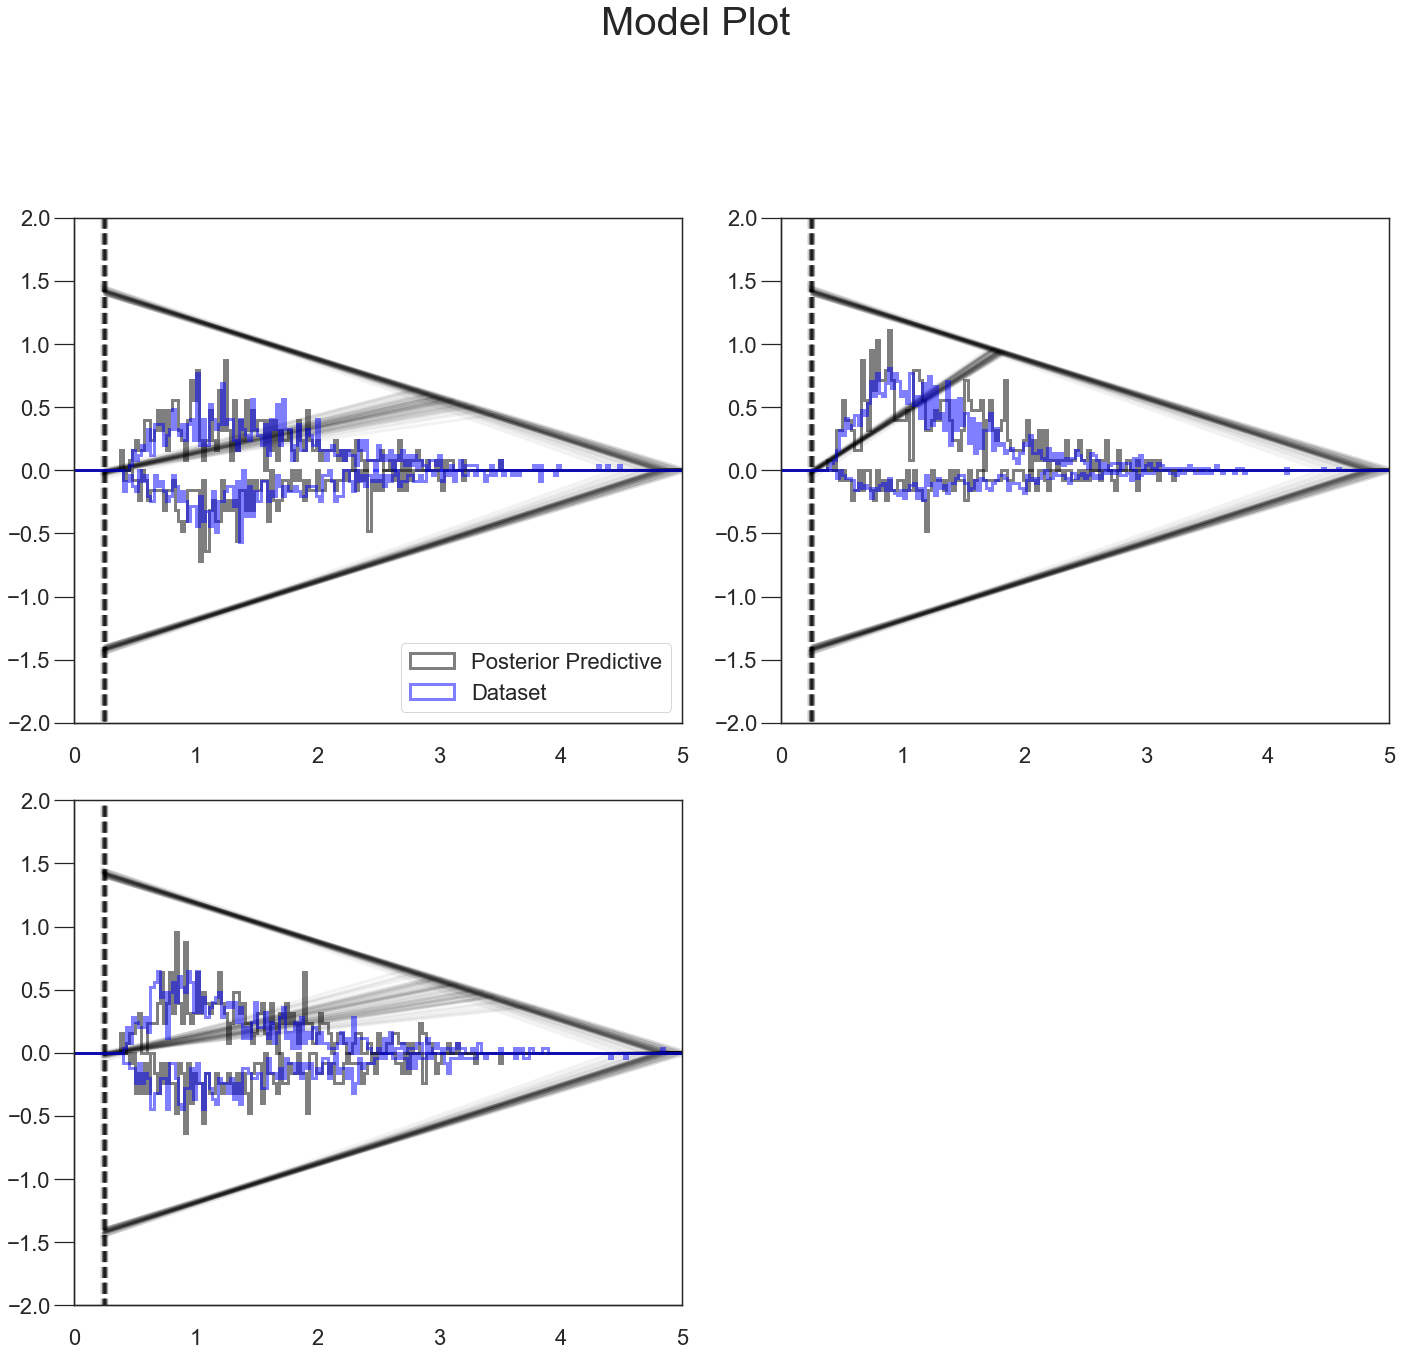

In [12]:
model_plot(posterior_samples = hddm_model.get_traces(),
           ground_truths_parameters = None,
           ground_truths_data = cav_data,
           model_gt = None,
           model_fitted = model,
           datatype = 'condition',
           condition_column = 'stim',
           input_hddm_trace = True,
           n_post_params = 50,
           n_plots = 4,
           cols = 2,
           show_model = True)

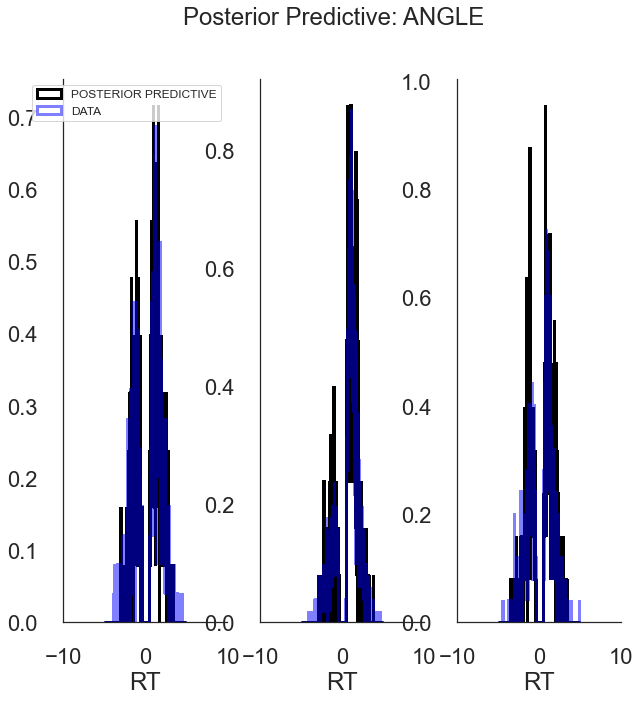

In [13]:
# Posterior Predictive: Do we generate meaningful data from the Posterior Model?
posterior_predictive_plot(ground_truths_parameters = None,
                          ground_truths_data = cav_data,
                          posterior_samples = hddm_model.get_traces(),
                          model_gt = None,
                          model_fitted = model,
                          n_post_params = 50,
                          n_plots = 3,
                          max_t = 5, 
                          input_hddm_trace = True,
                          datatype = 'condition',
                          condition_column = 'stim',
                          hist_linewidth = 3)

#### Basic Hierarchical Model

In [7]:
hddm_model = hddm.HDDMnn(cav_data, 
                         model = model,
                         informative = False,
                         include = includes, #is_group_model = True,
                         p_outlier = 0.05)

Now adding the HDDMBase include:
Include from inside HDDMBase:  {'a', 't', 'v'}
Recognized HDDMnn
RT
0.402
4.84
Response
[-1.  1.]
knodes
OrderedDict([('a', a), ('a_std', a_std), ('a_tau', a_tau), ('a_bottom', a_subj), ('v', v), ('v_std', v_std), ('v_tau', v_tau), ('v_bottom', v_subj), ('t', t), ('t_std', t_std), ('t_tau', t_tau), ('t_bottom', t_subj), ('z_trans', z_trans), ('z', z), ('z_std', z_std), ('z_tau', z_tau), ('z_subj_trans', z_subj_trans), ('z_bottom', z_subj), ('theta', theta), ('theta_std', theta_std), ('theta_tau', theta_tau), ('theta_bottom', theta_subj)])
wfpt parents: 
OrderedDict([('a', a_subj), ('v', v_subj), ('t', t_subj), ('z', z_subj), ('p_outlier', 0.05), ('w_outlier', 0.1), ('theta', theta_subj)])
Is Neural Net?  True
0.05


In [8]:
hddm_model.sample(nmcmc, burn = burn)

 [-----------------101%-----------------] 101 of 100 complete in 59.5 sec

a_subj.000
a_subj.000
a_subj.001
a_subj.001
a_subj.002
a_subj.002
a_subj.003
a_subj.003
a_subj.004
a_subj.004
a_subj.005
a_subj.005
a_subj.006
a_subj.006
a_subj.007
a_subj.007
a_subj.008
a_subj.008
a_subj.009
a_subj.009
a_subj.010
a_subj.010
a_subj.011
a_subj.011
a_subj.012
a_subj.012
a_subj.013
a_subj.013
v_subj.000
v_subj.000
v_subj.001
v_subj.001
v_subj.002
v_subj.002
v_subj.003
v_subj.003
v_subj.004
v_subj.004
v_subj.005
v_subj.005
v_subj.006
v_subj.006
v_subj.007
v_subj.007
v_subj.008
v_subj.008
v_subj.009
v_subj.009
v_subj.010
v_subj.010
v_subj.011
v_subj.011
v_subj.012
v_subj.012
v_subj.013
v_subj.013
t_subj.000
t_subj.000
t_subj.001
t_subj.001
t_subj.002
t_subj.002
t_subj.003
t_subj.003
t_subj.004
t_subj.004
t_subj.005
t_subj.005
t_subj.006
t_subj.006
t_subj.007
t_subj.007
t_subj.008
t_subj.008
t_subj.009
t_subj.009
t_subj.010
t_subj.010
t_subj.011
t_subj.011
t_subj.012
t_subj.012
t_subj.013
t_subj.013
z_subj_trans.000
z_subj_trans.000
z_subj_trans.001
z_subj_trans.001
z_subj_t

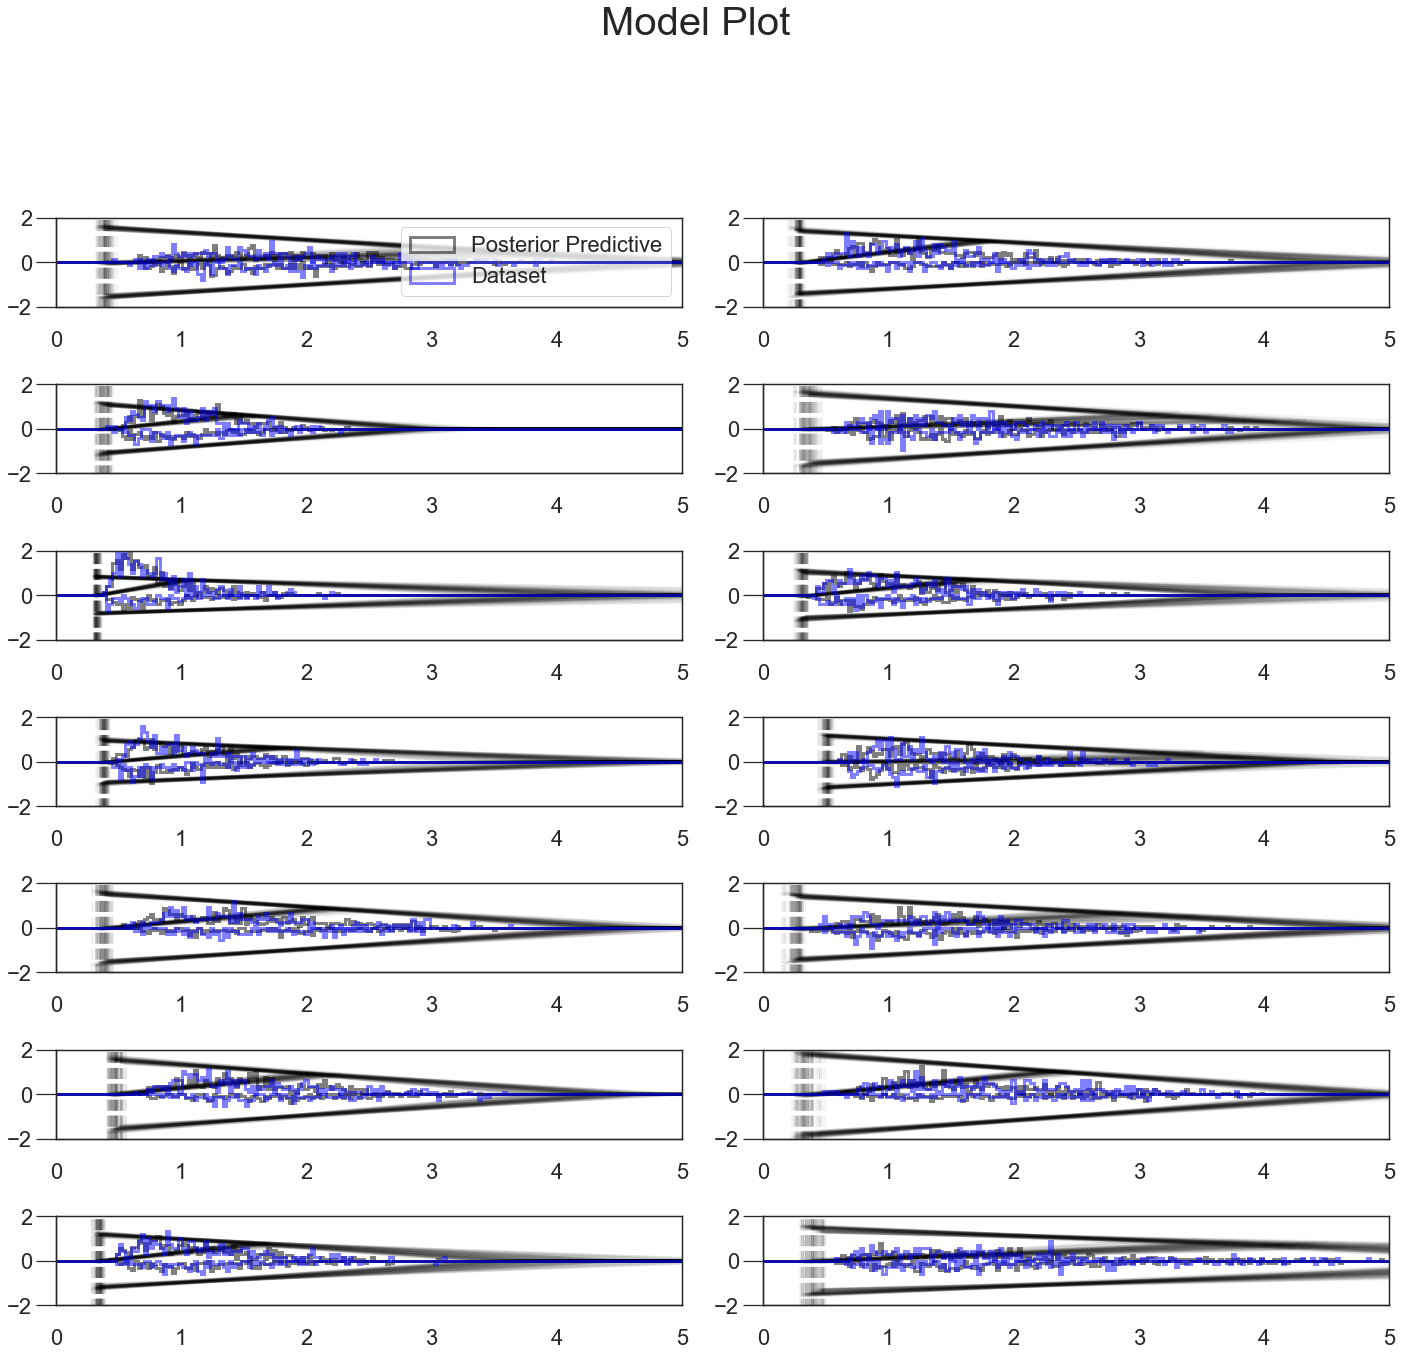

In [11]:
# Model plot: Visualize the models resulting from posterior samples along with the posterior predictives
model_plot(posterior_samples = hddm_model.get_traces(),
           ground_truths_parameters = None,
           ground_truths_data = cav_data,
           model_gt = None,
           model_fitted = model,
           datatype = 'hierarchical',
           input_hddm_trace = True,
           n_post_params = 50,
           n_plots = 4,
           cols = 2,
           show_model = True)

a_subj.000
a_subj.001
a_subj.002
a_subj.003
a_subj.004
a_subj.005
a_subj.006
a_subj.007
a_subj.008
a_subj.009
a_subj.010
a_subj.011
a_subj.012
a_subj.013
v_subj.000
v_subj.001
v_subj.002
v_subj.003
v_subj.004
v_subj.005
v_subj.006
v_subj.007
v_subj.008
v_subj.009
v_subj.010
v_subj.011
v_subj.012
v_subj.013
t_subj.000
t_subj.001
t_subj.002
t_subj.003
t_subj.004
t_subj.005
t_subj.006
t_subj.007
t_subj.008
t_subj.009
t_subj.010
t_subj.011
t_subj.012
t_subj.013
z_subj_trans.000
z_subj_trans.001
z_subj_trans.002
z_subj_trans.003
z_subj_trans.004
z_subj_trans.005
z_subj_trans.006
z_subj_trans.007
z_subj_trans.008
z_subj_trans.009
z_subj_trans.010
z_subj_trans.011
z_subj_trans.012
z_subj_trans.013
theta_subj.000
theta_subj.001
theta_subj.002
theta_subj.003
theta_subj.004
theta_subj.005
theta_subj.006
theta_subj.007
theta_subj.008
theta_subj.009
theta_subj.010
theta_subj.011
theta_subj.012
theta_subj.013
a_subj.000
a_subj.001
a_subj.002
a_subj.003
a_subj.004
a_subj.005
a_subj.006
a_subj.007
a_

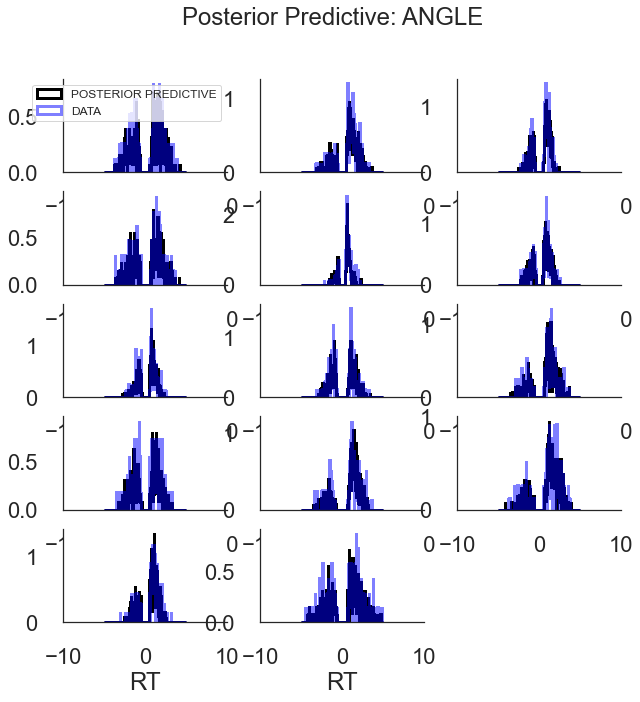

In [9]:
# Posterior Predictive: Do we generate meaningful data from the Posterior Model?
posterior_predictive_plot(ground_truths_parameters = None,
                          ground_truths_data = cav_data,
                          posterior_samples = hddm_model.get_traces(),
                          model_gt = None,
                          model_fitted = model,
                          n_post_params = 50,
                          n_plots = 1,
                          max_t = 5, 
                          input_hddm_trace = True,
                          datatype = 'hierarchical',
                          hist_linewidth = 3)

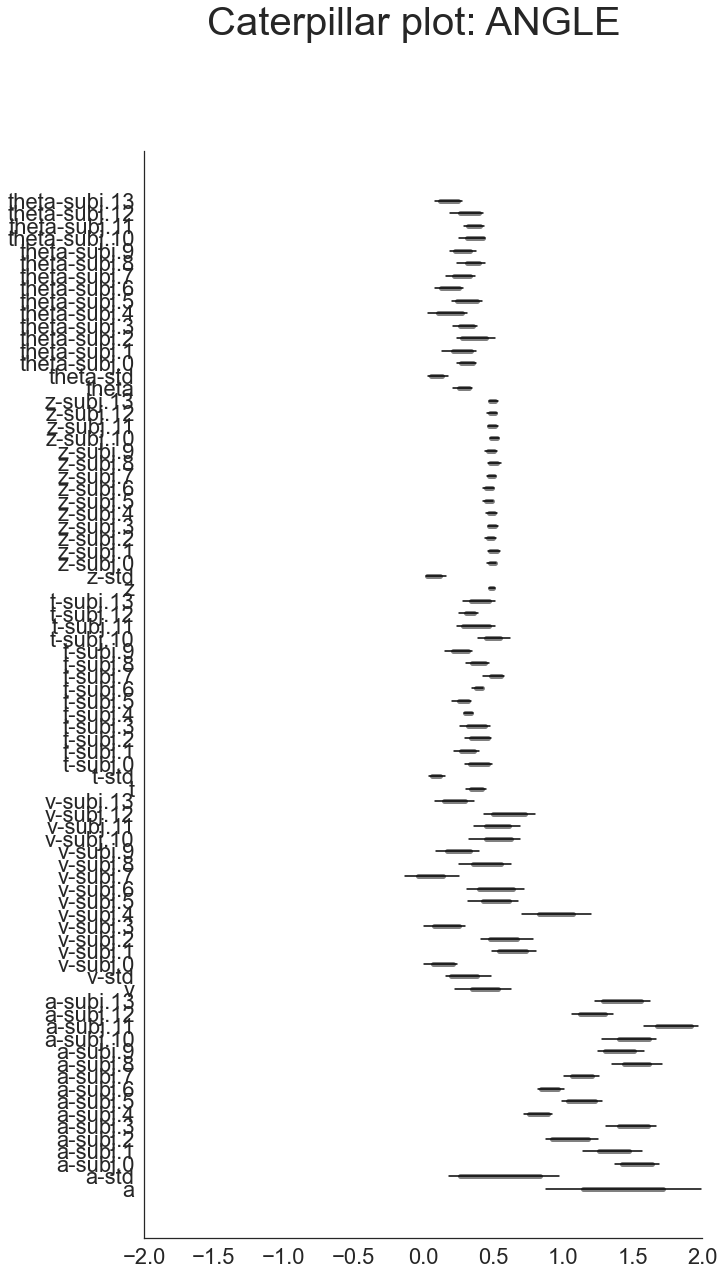

In [28]:
# Caterpillar Plot: 
caterpillar_plot(posterior_samples = hddm_model.get_traces(),
                 ground_truths = None, #weibull_params.values[0],
                 model = model,
                 datatype = 'hierarchical',
                 drop_sd = False)

### Note

This is just an example using the Cavanagh dataset. The angle model might not be the best choice here, and we are moreover ignoring the supplied conditions. 

# END

Hopefully this tutorial proves as a useful starting point for your application.